## Final Project Submission

Please fill out:
* Student name: **Claude Fried**
* Student pace: **Part-time**
* Scheduled project review date/time: 
* Instructor name: **James Irving**
* Blog post URL:


In [1]:
# Import necessary libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns

import folium

import plotly.express as px
import plotly.graph_objs as go

from ipywidgets import interact

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
%matplotlib inline

from itertools import combinations
from yellowbrick.regressor import CooksDistance

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
plt.style.use(['ggplot', 'seaborn-poster'])

# Introduction:

When it comes to selling a house, people always have a different perception of what the experience should be like. Sometimes a seller has sentimental attachment to the house they grew up in (or raised their children in). Other times, they feel that investments and improvements they've made to the house and/or property are worth more than they actually are.

Regardless of a seller's feelings, there are concrete ways to look at a house and determine an appropriate value.

In this project, we look at a dataset from *King County House Sales* and try to create some insight into the housing market in that area. The goal is to create a model which is highly interpretable and helps determine the relative value of different aspects of the house.

In order to make insights, we will use the *OSEMN* process.
> * **O**btain **S**crub **E**xplore **M**odel i**N**terpret - **OSEMN**

*Looking in detail:*
> **Obtain**: In this project, this is as easy as loading in the given dataset.
>
> **Scrub**: We will do general cleaning of the data. This includes:
>> Casting columns to the correct data types.
>> Filling in missing values.
>> Normalizing the data (in this case, we'll be making one model with normalized / transformed data and another model without).
>> Checking for multicollinearity between variables.
> 
>  **Explore**: We will look at the data and see its relationship to itself and the target variable (in this case, the price of a home).
> 
> **Model**: We will create Linear Regression models in order to have an interpretable result and concrete deliverables to sellers on the factors which produce the biggest change to home price.
> 
> **Interpret**: Finally, we can use our results and draw conclusions.

###  Helper Functions.

In [3]:
def get_model(target_col, dataframe, predictors='all'):
    """
    In:
        target_col: variable name for which we are predicting
        dataframe: the relevant DataFrame
        predictors: 'all' or a list of column names
    Out:
        returns a fitted model using statsmodels.formula.api
    """
    target = target_col
    if predictors == 'all':
        variables = [v for v in dataframe.columns if v != target]
    else:
        variables = predictors
    varis = '+'.join(variables)

    formula = f'{target}~{varis}'

    return smf.ols(formula=formula, data=dataframe).fit()


def get_data_table(model, include_intercept=False):
    """
    In:
        model: a fitted model using statsmodels
    Out:
        a pd.DataFrame object with the model's second table's data
    """
    data_table = pd.DataFrame(model.summary().tables[1].data)
    data_table.columns = data_table.iloc[0]
    data_table.drop(0, inplace=True)
    data_table.set_index('', inplace=True)
    data_table = data_table.astype(float)
    
    if not include_intercept:
        data_table = data_table[1:]
    
    return data_table


def show_all_nans(dataframe):
    """
    In:
        dataframe which you're investigating
    Out:
        a printout of details on the NaN values present
    """
    any_nan = False
    
    for col in dataframe.columns:
        if dataframe[col].isna().any():
            any_nan = True
            print(f'***{col}***')
            print('NaN count:', dataframe[col].isna().sum())
            display(dataframe[col].value_counts(dropna=False))
    
    if not any_nan:
        print('**No NaN values found.**')
        
        
def iqr_fence(series):
    """
    In:
        Series which you want to analyze.
    Out:
        Tuple of (a, b) where a=Q1-1.5(IQR), b=Q3+1.5(IQR)
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = stats.iqr(series)
    
    a = q1 - (1.5 * iqr)
    b = q3 + (1.5 * iqr)
    
    return (a, b)


def show_iqr_outliers(dataframe):
    """
    In:
        Dataframe to show outliers.
    Out:
        Printout of outliers according to iqr.
    """
    for col in dataframe.columns:
        try:
            a, b = iqr_fence(dataframe[col])
            outliers = dataframe[col][(dataframe[col] < a) | 
                                         (dataframe[col] > b)]
            len_out = len(outliers)
            len_data = len(dataframe)
            print(f'{col.title()}:')
            print(f'{round((len_out/len_data)*100, 2)}%\t{len_out}/{len_data}\n')
        except TypeError:
            pass
            

def get_iqr_outliers_index(series):
    """
    In:
        Series to analyze.
    Out:
        Indexes which fall outside the iqr fence (1.5*iqr +- q1|q3)
    """
    try:
        a, b = iqr_fence(series)
        return series[(series < a) | (series > b)].index
    except TypeError:
        return []
    
    
def stepwise_selection(target_data, 
                       variable_data, 
                       included_lst=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05):
    """
    In:
        target_data: a dataframe of the dependent variable.
        variable_data: a dataframe of the independent variables.
        included_lst: a list of columns to begin with in the model.
        threshold_in: the pvalue of the relationship required to include the dependent variable.
        threshold_out: the pvalue of the relationship required to remove the dependent variable.
    Out:
        an list of variables that are impactful to the model.
    """
    while True:
        # When a variable is removed or added, we will loop again.
        # If nothing has been added or removed, we will return the list.
        changed = False
        
        # Create a list of 'excluded' columns.
        excluded = list(set(variable_data.columns) - set(included_lst)) # starts as all
        
        # Set up pd.Series to hold the pvalues of the variables.
        new_pval = pd.Series(index=[excluded], dtype='float64')
        
        # Iterate through the columns and update the pvalue in the abovs Series.
        for col in excluded:
            
            # Create a model (with sm.OLS instaed of smf.ols())
            model = sm.OLS(target_data, 
                           sm.add_constant(
                               pd.DataFrame(variable_data[included_lst+[col]])
                               )
                          ).fit()
            
            # Set our Series to hold the pvalues.
            new_pval[col] = model.pvalues[col]
            
        # Figure out the best (lowest) pvalue and whether it is smaller than threshold_in.
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            included_lst.append(new_pval.idxmin()[0])
            changed = True
            
        ##########
        # "Step Backward" - look for variables which don't have a significant effect.
        ##########
        
        # Make a new model from the included_lst and find the worst p_value.
        model = sm.OLS(target_data, 
                       sm.add_constant(
                               pd.DataFrame(variable_data[included_lst])
                               )).fit()
        curr_pvals = model.pvalues.iloc[1:] # not including the intercept
        worst_pval = curr_pvals.max()
        
        # Remove from included_lst if it's greater than the threshold_out.
        if worst_pval > threshold_out:
            worst = curr_pvals.index[curr_pvals.argmax()]
            included_lst.remove(worst)
            changed = True
        if not changed:
            return included_lst

# Data Processing & Model 1

## Obtain

*The first step to any intelligible conversation in data is to obtain the data you're working with. Thankfully in this case, the data is simply downloaded. Rather than being gathered from the world, it is gathered for me.*

In [4]:
df_raw = pd.read_csv('kc_house_data.csv')
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


*The dataset looks reasonably self-explanatory. We have columns for details on each house including its **sale price** (our target variable).*

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
# Read column_names file.
with open('column_names.md') as f:
    info = f.read()

In [7]:
split_info = info.split('\n')[1:-1]
split_info

['* **id** - unique identified for a house',
 '* **dateDate** - house was sold',
 '* **pricePrice** -  is prediction target',
 '* **bedroomsNumber** -  of Bedrooms/House',
 '* **bathroomsNumber** -  of bathrooms/bedrooms',
 '* **sqft_livingsquare** -  footage of the home',
 '* **sqft_lotsquare** -  footage of the lot',
 '* **floorsTotal** -  floors (levels) in house',
 '* **waterfront** - House which has a view to a waterfront',
 '* **view** - Has been viewed',
 '* **condition** - How good the condition is ( Overall )',
 '* **grade** - overall grade given to the housing unit, based on King County grading system',
 '* **sqft_above** - square footage of house apart from basement',
 '* **sqft_basement** - square footage of the basement',
 '* **yr_built** - Built Year',
 '* **yr_renovated** - Year when house was renovated',
 '* **zipcode** - zip',
 '* **lat** - Latitude coordinate',
 '* **long** - Longitude coordinate',
 '* **sqft_living15** - The square footage of interior housing living 

## Scrub

**Outline**

- Casting columns to the appropriate data types.

- Identifying and dealing with null values appropriately.

- Removing columns that aren't required for modeling.

- Checking for and dealing with multicollinearity.

- Normalizing the data.*

First, we should get a broad overview of each of the columns of the dataframe. What is the distribution like? Are there any `NaN` values I should prepare for? What kind of values are present?

* **id** - unique identified for a house
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	21420


795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

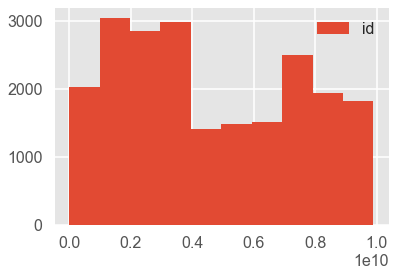


* **dateDate** - house was sold
Type:	object
NaN:	0/21597 (0.0%)
Unique:	372


6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
            ... 
5/15/2015      1
1/10/2015      1
8/30/2014      1
1/31/2015      1
5/17/2014      1
Name: date, Length: 372, dtype: int64

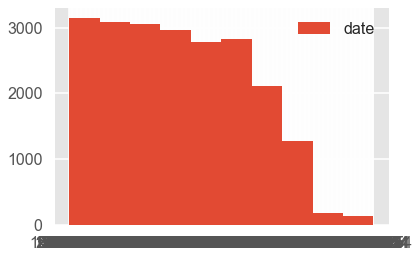


* **pricePrice** -  is prediction target
Type:	float64
NaN:	0/21597 (0.0%)
Unique:	3622


350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64

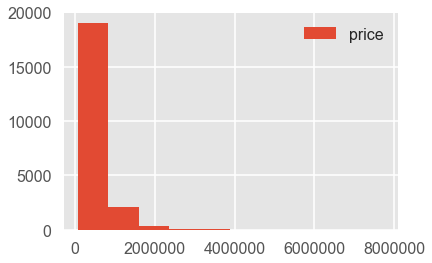


* **bedroomsNumber** -  of Bedrooms/House
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	12


3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

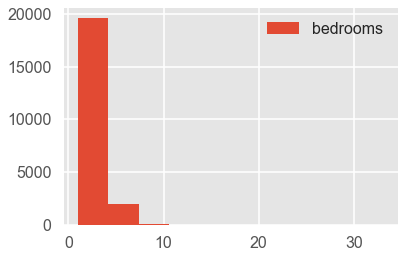


* **bathroomsNumber** -  of bathrooms/bedrooms
Type:	float64
NaN:	0/21597 (0.0%)
Unique:	29


2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

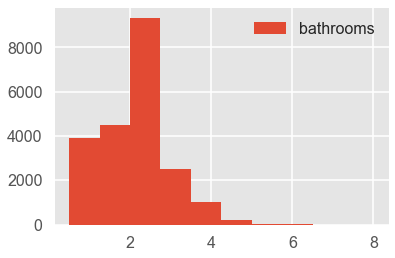


* **sqft_livingsquare** -  footage of the home
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	1034


1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

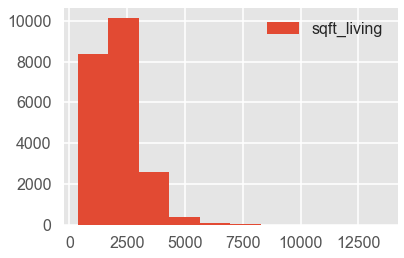


* **sqft_lotsquare** -  footage of the lot
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	9776


5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

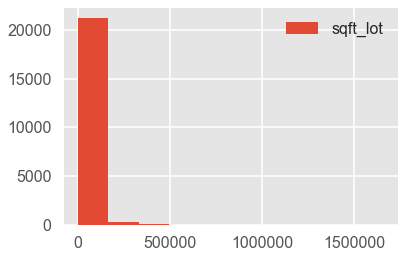


* **floorsTotal** -  floors (levels) in house
Type:	float64
NaN:	0/21597 (0.0%)
Unique:	6


1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

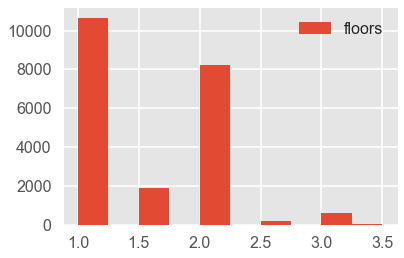


* **waterfront** - House which has a view to a waterfront
Type:	float64
NaN:	2376/21597 (11.0%)
Unique:	3


0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



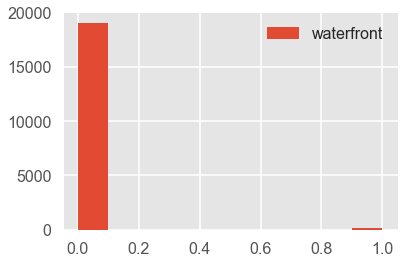


* **view** - Has been viewed
Type:	float64
NaN:	63/21597 (0.29%)
Unique:	6


0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
NaN       63
Name: view, dtype: int64

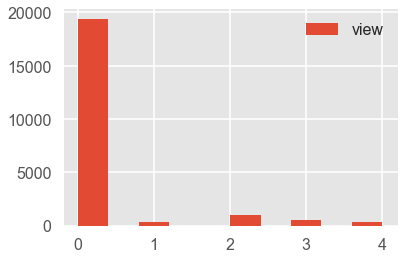


* **condition** - How good the condition is ( Overall )
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	5


3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

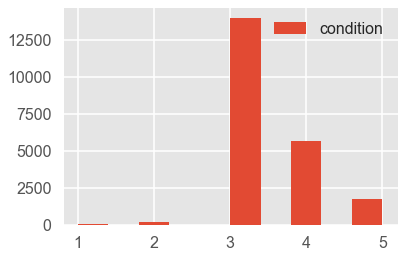


* **grade** - overall grade given to the housing unit, based on King County grading system
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	11


7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

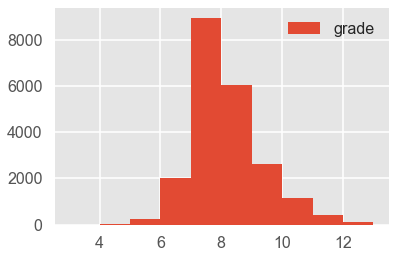


* **sqft_above** - square footage of house apart from basement
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	942


1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

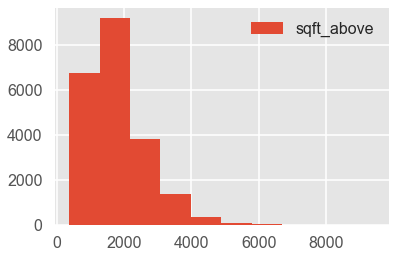


* **sqft_basement** - square footage of the basement
Type:	object
NaN:	0/21597 (0.0%)
Unique:	304


0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1990.0        1
475.0         1
2810.0        1
3480.0        1
2580.0        1
Name: sqft_basement, Length: 304, dtype: int64

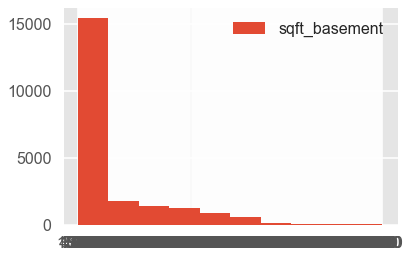


* **yr_built** - Built Year
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	116


2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

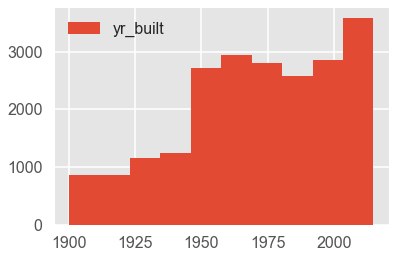


* **yr_renovated** - Year when house was renovated
Type:	float64
NaN:	3842/21597 (17.79%)
Unique:	71


0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

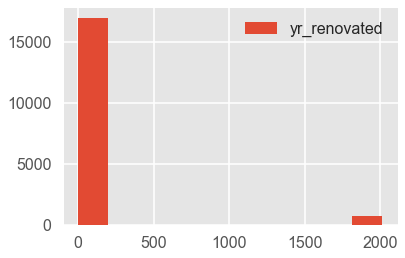


* **zipcode** - zip
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	70


98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

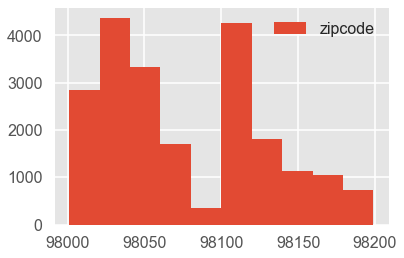


* **lat** - Latitude coordinate
Type:	float64
NaN:	0/21597 (0.0%)
Unique:	5033


47.6624    17
47.5491    17
47.5322    17
47.6846    17
47.6711    16
           ..
47.2785     1
47.4162     1
47.3870     1
47.2313     1
47.2715     1
Name: lat, Length: 5033, dtype: int64

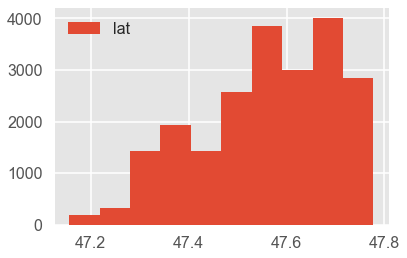


* **long** - Longitude coordinate
Type:	float64
NaN:	0/21597 (0.0%)
Unique:	751


-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
           ... 
-121.403      1
-121.804      1
-121.726      1
-121.895      1
-121.893      1
Name: long, Length: 751, dtype: int64

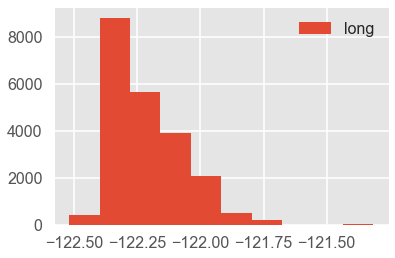


* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	777


1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

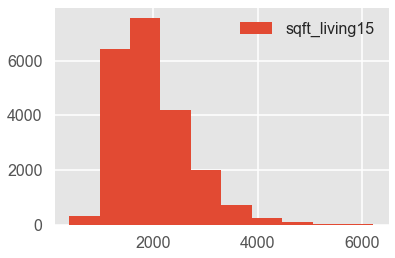


* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors
Type:	int64
NaN:	0/21597 (0.0%)
Unique:	8682


5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

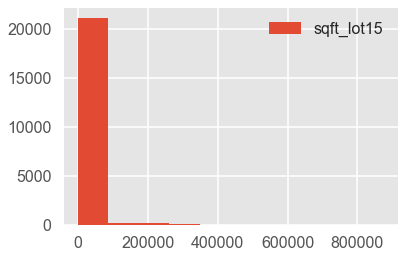

In [8]:
# Research the columns' value_counts()
# Visualize the columns.
for i, col in enumerate(df_raw.columns):
    col_series = df_raw[col]
    na = col_series.isna().sum()
    col_descript = col_series.value_counts(dropna=False)
    
    # Header
    print(split_info[i]) # Print the description line from the .txt file.
    print(f'Type:\t{col_series.dtype}')
    
    # NaN count & NaN %
    print(
        f'NaN:\t{na}/{len(col_series)} ({round(na/len(col_series), 4) * 100}%)'
        )
    
    # Unique values.
    print(f'Unique:\t{len(col_descript)}')
    
    # Table & histogram.
    display(col_descript)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(df_raw[col], label=col)
    plt.legend()
    plt.show()
    print()

#### Preliminary investigation.

***There are two things that stand out to me that I'd like to address before anything else.***

> 1. There are *fake* `NaN` values in the `sqft_basement` column (represented by `'?'`). Before moving forward I'm going to cast those values as proper `NaN` for consistency.
> 
>
> 2. There are several duplicated values in the `id` column which I did not expect (I assumed there to be one house `id` per entry. That means one of two things:
    * there are **duplicate rows**, or
    * **a single house can show up multiple times.**

First with the obvious alteration in `sqft_basement`:

In [9]:
# Replace sqft_basement '?' value with np.nan.
df_raw['sqft_basement'] = df_raw['sqft_basement'].replace('?', np.nan)

And now we figure out what we're dealing with in terms of `id`.

In [10]:
# Find homes with duplicated id column.

# Get a set of ids where the value_count is more than 1.
duplicate_ids = set(
    df_raw['id'].value_counts()[df_raw['id'].value_counts() > 1].index
    )

# Get the indexes of rows whose id is in duplicated_ids.
duplicate_idx = [i for i, info in df_raw.iterrows() 
                 if info['id'] in duplicate_ids]

# Locate those rows.
duplicate_df = df_raw.iloc[duplicate_idx].sort_values('id')
duplicate_df.head(6)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,0.0,0.0,...,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
2494,1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,NaN,0.0,...,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
16800,7200179,10/16/2014,150000.0,2,1.00,840,12750,1.0,0.0,0.0,...,6,840,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969
16801,7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,0.0,0.0,...,6,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969
11422,109200390,10/20/2014,250000.0,3,1.75,1480,3900,1.0,0.0,0.0,...,7,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956
11421,109200390,8/20/2014,245000.0,3,1.75,1480,3900,1.0,0.0,0.0,...,7,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956


We can notice that the houses with the same `id` have different attributes (note the `date` column).

In [11]:
# Any duplicate rows?
duplicate_df.duplicated(keep=False).any()

False

So we importantly clarified that `id` is a `house_id`, meaning if a house was sold twice, it will show up as two entries.

I notice right away that there are some `NaN` values in this `duplicated_df`. Before I make blanket decisions on filling in `NaN`s, it would be smart to use this dataframe to help fill in some missing values.

***For example:*** *If a `house_id` has an value for `waterfront` if one entry and is missing in another entry, we can (somewhat) safely fill them to match.*

In [12]:
# Total number of NaN values in the original df.
before = df_raw.isna().sum().sum()

# Get a list of `id`s who have any NaN values. 
ids_nan = list(duplicate_df[duplicate_df.isnull().any(axis=1)]['id'])

# Iterate through these `id`s.
for ident in ids_nan:
    # Get all entries of this `id`.
    d = duplicate_df[duplicate_df['id'] == ident]
    
    # Get the columns which have a NaN value in them.
    nan_cols = d.loc[:,d.isna().any()]
    
    # Set up a 'replacement_dct' to insert values into the original df.
    dct = {}
    
    # Iterare through the columns with a NaN.
    for col in nan_cols:
        # If all the values are NaN, do nothing.
        if nan_cols[col].isna().all():
            continue
            
        # Assign the mode() of the column to the dct (eg: {column_name: mode()})
        dct[col] = nan_cols[col].mode()[0]
        
    # Iterate through the indexes of the `id`s for this house.
    for i in nan_cols.index:
        # Iterate through the columns that need to be inserted.
        for col in dct:
            # Assign the value to the row, column (using the preferred df.at[]).
            df_raw.at[i, col] = dct[col]

# Total number of NaN values after filling.
after = df_raw.isna().sum().sum()

In [13]:
print(f'Total NaN before:\t{before}')
print(f'Total NaN after:\t{after}')
print(f'Total NaN Removed:\t{before-after}')

Total NaN before:	6735
Total NaN after:	6634
Total NaN Removed:	101


### Casting columns to the appropriate data types.

This should be relatively simple - make sure that numbers are numbers and so on...

In [14]:
# Set up a copy of the dataframe before altering it.
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19261 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21147 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17812 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [15]:
# Cast 'date' to datetime object.
df['date'] = pd.to_datetime(df['date'])
df['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [16]:
# Double-check that price should actually be an integer 
# (by checking the difference btwn rounded and pure Series').
(df['price'] - round(df['price'])).value_counts()

0.0    21597
Name: price, dtype: int64

In [17]:
# Cast price as integer.
df['price'] = df['price'].astype(int)
df['price']

0        221900
1        538000
2        180000
3        604000
4        510000
          ...  
21592    360000
21593    400000
21594    402101
21595    400000
21596    325000
Name: price, Length: 21597, dtype: int32

In [18]:
# Cast 'waterfront' as category.
df['waterfront'] = df['waterfront'].astype('category')
df['waterfront']

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21592    0.0
21593    0.0
21594    0.0
21595    NaN
21596    0.0
Name: waterfront, Length: 21597, dtype: category
Categories (2, float64): [0.0, 1.0]

In [19]:
# Cast sqft_basement as a float.
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [20]:
# Cast 'zipcode' to a categorical.
df['zipcode'] = df['zipcode'].astype('category')

In [21]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  int32         
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19261 non-null  category      
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21147 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1781

Now that the data has the proper type, it's time then to deal with missing values.

### Identifying and dealing with null values.

In [23]:
# Get details on missing values.
show_all_nans(df)

***waterfront***
NaN count: 2336


0.0    19115
NaN     2336
1.0      146
Name: waterfront, dtype: int64

***view***
NaN count: 63


0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
NaN       63
Name: view, dtype: int64

***sqft_basement***
NaN count: 450


0.0       12829
NaN         450
600.0       217
700.0       209
500.0       209
          ...  
588.0         1
1920.0        1
2390.0        1
1245.0        1
1135.0        1
Name: sqft_basement, Length: 304, dtype: int64

***yr_renovated***
NaN count: 3785


0.0       17068
NaN        3785
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

For **waterfront**, there are *100x* more houses that are not on the waterfront than are.

It would be simple to fill them all to be `non-waterfront`, but I want to see if a map can help shed some light.


#### Q: Can we use a map to determine `NaN` values from `'waterfront'`?

In [24]:
# Use folium to map the houses that are on the waterfront and the NaN values.
fol_map = folium.Map(location=[47.5112, -122.257], zoom_start=9)

# Add NaN markers.
# Taking sample to improve performance.
for i, row in df[df['waterfront'].isna()].sample(150, 
                                                 random_state=51).iterrows():
    marker = folium.Marker(
        [row['lat'], row['long']],
        icon=folium.Icon(color='black')
        )
    marker.add_to(fol_map)
    
# Add 'waterfront' properties.
for i, row in df[df['waterfront'] == 1.0].iterrows():
    marker = folium.Marker(
        [row['lat'], row['long']],
        icon=folium.Icon(color='green')
        )
    marker.add_to(fol_map)

# Show map.
fol_map

As a generality, it looks like the NaN houses from this sample are inland compared to the `waterfront` homes.

#### Q: Are there any zipcodes where all or most of the houses are labeled as `waterfront`?

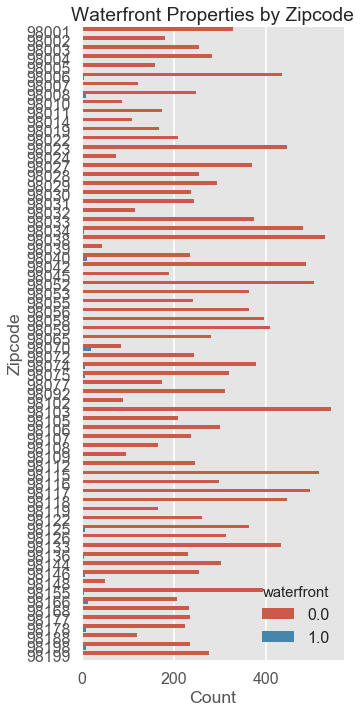

In [25]:
# Group by zipcode & get the number of entries for each category in 'waterfront'
s = df.groupby('zipcode').waterfront.value_counts(dropna=False)
s = pd.DataFrame(s)
s.columns = ['count']
s.reset_index(inplace=True)

# Plot the difference in values for each zipcode.
fig, ax = plt.subplots(figsize=(5,10))

# sns.catplot(y='zipcode', x='price', hue='waterfront', 
#             height=12, aspect=0.5, data=df)

sns.barplot(y='zipcode', x='count', hue='waterfront', data=s, ax=ax)
ax.set(title='Waterfront Properties by Zipcode', 
       xlabel='Count', ylabel='Zipcode')
fig.tight_layout()

There is never a case where there are even close to as many `waterfront` homes as non-waterfront, so we will simply fill in the NaNs as *non-waterfront*.

In [26]:
# Fill NaNs with non-waterfront.
df['waterfront'] = df['waterfront'].fillna(0.0)
df['waterfront']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21592    0.0
21593    0.0
21594    0.0
21595    0.0
21596    0.0
Name: waterfront, Length: 21597, dtype: category
Categories (2, float64): [0.0, 1.0]

In [27]:
show_all_nans(df)

***view***
NaN count: 63


0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
NaN       63
Name: view, dtype: int64

***sqft_basement***
NaN count: 450


0.0       12829
NaN         450
600.0       217
700.0       209
500.0       209
          ...  
588.0         1
1920.0        1
2390.0        1
1245.0        1
1135.0        1
Name: sqft_basement, Length: 304, dtype: int64

***yr_renovated***
NaN count: 3785


0.0       17068
NaN        3785
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

`view` I will treat much more simply and fill with the mode of the column.

In [28]:
# Fill 'view' column with the mode of the column.
df['view'] = df['view'].fillna(df['view'].mode()[0])
df['view']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21592    0.0
21593    0.0
21594    0.0
21595    0.0
21596    0.0
Name: view, Length: 21597, dtype: float64

In [29]:
show_all_nans(df)

***sqft_basement***
NaN count: 450


0.0       12829
NaN         450
600.0       217
700.0       209
500.0       209
          ...  
588.0         1
1920.0        1
2390.0        1
1245.0        1
1135.0        1
Name: sqft_basement, Length: 304, dtype: int64

***yr_renovated***
NaN count: 3785


0.0       17068
NaN        3785
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

There is a secret embedding of `sqft_basement` which we can use to fill the `NaN` values here.

The difference between columns `sqft_living` and `sqft_above` will give us the remaining size of the basement. 

In [30]:
# Checking for consistency.
## Find out the rows in which 'sqft_living' minus 'sqft_above' 
## does not equal 'sqft_basement'.
df[df['sqft_living'] - df['sqft_above'] != df['sqft_basement']]['sqft_basement']

6       NaN
18      NaN
42      NaN
79      NaN
112     NaN
         ..
21442   NaN
21447   NaN
21473   NaN
21519   NaN
21581   NaN
Name: sqft_basement, Length: 450, dtype: float64

These are indeed the 450 `NaN` values from this column **which means** *the entries where `sqft_basement` has a value, our assumption is consistent in the data: `df['sqft_living'] - df['sqft_above'] == df['sqft_basement']`*.

I can simply then assign the `sqft_basement` column to be the difference between `sqft_living` and `sqft_above`.

In [31]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df['sqft_basement']

0          0
1        400
2          0
3        910
4          0
        ... 
21592      0
21593      0
21594      0
21595      0
21596      0
Name: sqft_basement, Length: 21597, dtype: int64

In [32]:
show_all_nans(df)

***yr_renovated***
NaN count: 3785


0.0       17068
NaN        3785
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

**Note**: `yr_renovated` NaNs are most likely implications that there was no renovation. 

In [33]:
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['yr_renovated']

0           0.0
1        1991.0
2           0.0
3           0.0
4           0.0
          ...  
21592       0.0
21593       0.0
21594       0.0
21595       0.0
21596       0.0
Name: yr_renovated, Length: 21597, dtype: float64

#### Re-casting dtypes


There is one column which I feel should be re-organized into boolean categories.

There is also one column which I will divide up in order to have more manageable categories.

The first column is `yr_renovated`. I believe this should also simply represent whether or not a property has been renovated or not.

In [34]:
df['yr_renovated'].value_counts()

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [35]:
# Create column 'renovated' and drop 'yr_renovated'.
df['renovated'] = (df['yr_renovated'] > 0).astype('category')
df.drop('yr_renovated', axis=1, inplace=True)

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,False
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,True
2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,False
3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,False
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,False


Finally, I need to decide whether to cast `yr_built` to a categorical *or* a numerical `decade_built`.

In [36]:
# Get decade built with a simple shortcut.
df['decade_built'] = df['yr_built'].astype(str).apply(lambda x: x[:3]+'0')

# Cast as numerical.
df['decade_built'] = df['decade_built'].astype('int')

# Drop 'yr_built'.
df.drop('yr_built', axis=1, inplace=True)

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,decade_built
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0,98178,47.5112,-122.257,1340,5650,False,1950
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400,98125,47.7210,-122.319,1690,7639,True,1950
2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0,98028,47.7379,-122.233,2720,8062,False,1930
3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910,98136,47.5208,-122.393,1360,5000,False,1960
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0,98074,47.6168,-122.045,1800,7503,False,1980


#### Q: Does `decade_built` behave as a numerical column?

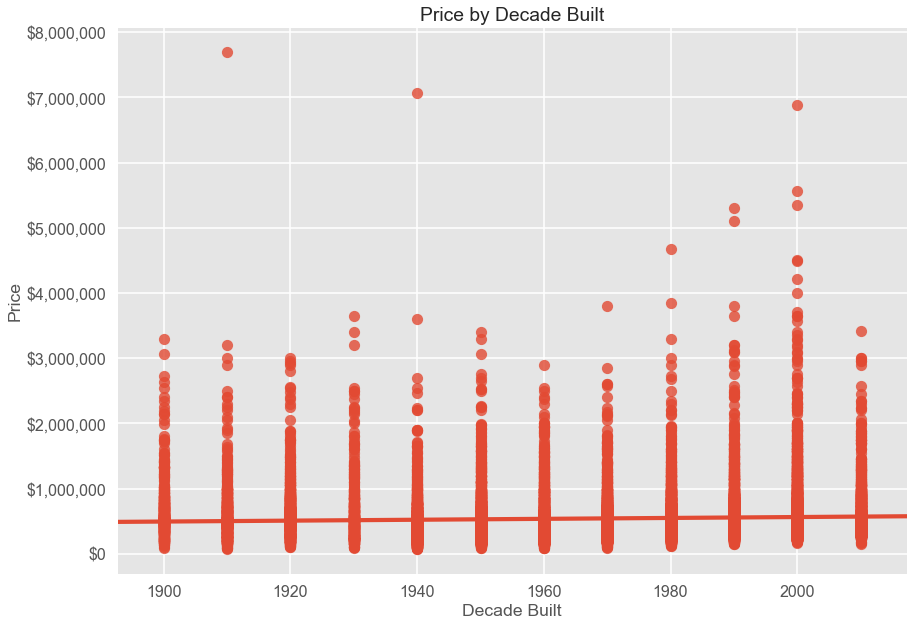

In [37]:
# Check if the column should be numerical rather than categorical.
fig, ax = plt.subplots()
sns.regplot(x='decade_built', y='price', data=df, ax=ax)
ax.set(title='Price by Decade Built', xlabel='Decade Built', ylabel='Price')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
fig.tight_layout()

Since there's no linear relationship, I'll use a categorical configuration.

In [38]:
df['decade_built'] = df['decade_built'].astype('category')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  int32         
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  category      
 9   view           21597 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  int64         
 14  zipcode        21597 non-null  category      
 15  lat            2159

### Remove columns that aren't required for modeling

There are some obvious columns which will no longer be useful for the model - `['id', 'lat', 'long']` off the bat for example.

I may be able to use `date` as a predictor if there seem to be trends related to closing date.

#### Q: Is there a trend from year to year in terms of home sale price?

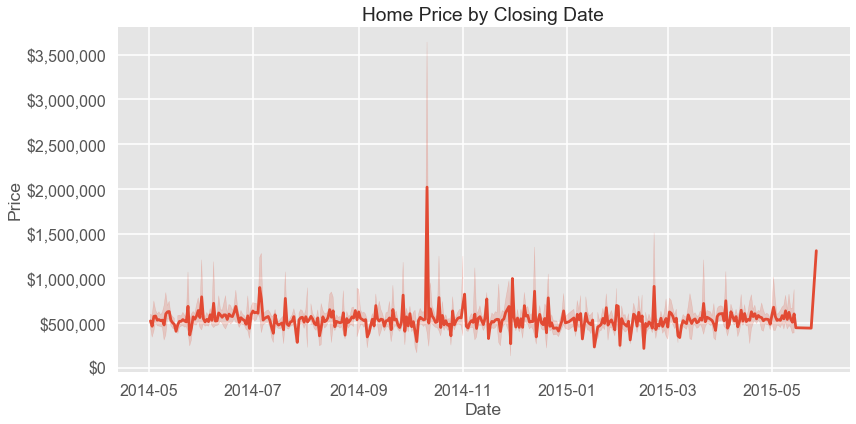

In [40]:
# Plot price against closing date.
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='date', y='price', data=df, ax=ax)
ax.set(title='Home Price by Closing Date', xlabel='Date', ylabel='Price')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()

There is no trend according to `closing date`, so we can drop this column as well.

In [41]:
unused = df[['id', 'lat', 'long', 'date']].copy()
df.drop(columns=unused.columns, inplace=True)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,renovated,decade_built
0,221900,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0,98178,1340,5650,False,1950
1,538000,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,98125,1690,7639,True,1950
2,180000,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,98028,2720,8062,False,1930
3,604000,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,98136,1360,5000,False,1960
4,510000,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,98074,1800,7503,False,1980


### Checking for and dealing with multicollinearity

Multicollinearity occurs when two or more predictors (x-variables) have enough of a correlation that you're not sure which is responsible for the predictive power.

Any variables that have a strong correlation should be dropped or combined in order to maintain the model's integrity.

#### Q: Which variables are most highly correlated (and should be dropped)?

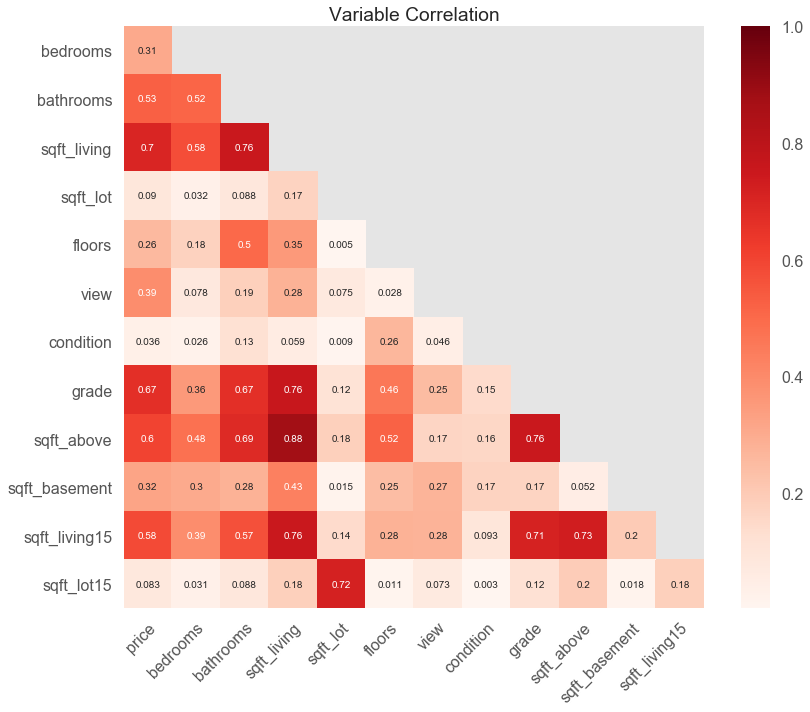

In [42]:
# Heatmap.
fig, ax = plt.subplots(figsize=(12,10))

# corr = df.drop('price', axis=1).corr().abs().round(3)
corr = df.corr().abs().round(3)

# Set a 'mask' for the upper half of the heatmap.
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Reds', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Variable Correlation')

# Hack to fix the cutoff squares and remove empty row and column.
ax.set_ylim(len(corr), 1)
ax.set_xlim(xmax=len(corr)-1)

fig.tight_layout()

In [43]:
# Get the top correlations.
corr_values = corr.abs().stack().reset_index().sort_values(0, ascending=False)

corr_values['pairs'] = list(zip(corr_values['level_0'], 
                                corr_values['level_1']))
corr_values.set_index('pairs', inplace=True)
corr_values.drop(columns=['level_0', 'level_1'], inplace=True)
corr_values.columns = ['cc']

top_corr = corr_values[(corr_values['cc'] > 0.75) & (corr_values['cc'] < 1)]

# Take alternating rows (removing duplicated pairs).
top_corr = top_corr.iloc[::2]
top_corr

,cc
pairs,
"(sqft_above, sqft_living)",0.876
"(grade, sqft_living)",0.763
"(grade, sqft_above)",0.756
"(sqft_living, bathrooms)",0.756
"(sqft_living, sqft_living15)",0.756


In [44]:
corr_features = list(set([feature 
                          for pair in top_corr.index.values
                          for feature in pair]))
corr_features

['sqft_living15', 'bathrooms', 'sqft_living', 'grade', 'sqft_above']

*For these highly correlated features, I want to find out which features are least-correlated with our target (`price`).*

In [45]:
# Find how the highly-correlated features correlate with the target (price).
corr_with_price = df[['price']+corr_features].corr()['price']
corr_with_price.sort_values()

bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
grade            0.667951
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

*Since **`sqft_living`** shows up with the most multicollinearity, there's a strong incentive to drop it. We will retain a lot of the information in its value with `sqft_above`, so hopefully we won't lose too much.*

In [46]:
# Drop sqft_living.
df.drop('sqft_living', axis=1, inplace=True)

df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,renovated,decade_built
0,221900,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0,98178,1340,5650,False,1950
1,538000,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400,98125,1690,7639,True,1950
2,180000,2,1.00,10000,1.0,0.0,0.0,3,6,770,0,98028,2720,8062,False,1930
3,604000,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910,98136,1360,5000,False,1960
4,510000,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0,98074,1800,7503,False,1980


### Normalizing the data (Model 1)

#### z-score
The last step for *Scrubbing* is to normalize and one-hot-encode.

I'll be using z-scores to normalize in order to still have a clear sense of the distributions in case I'll need it.

In [47]:
# Set a copy of the dataframe in case we want to refer to the original.
normalized = df.copy()

In [48]:
# Separate columns by type.
target = 'price'
numerical_cols = [c for c in df.select_dtypes('number').columns 
                  if c != target]
categorical_cols = [c for c in df.columns 
                    if c not in numerical_cols and c != target]

numerical_cols, categorical_cols

(['bedrooms',
  'bathrooms',
  'sqft_lot',
  'floors',
  'view',
  'condition',
  'grade',
  'sqft_above',
  'sqft_basement',
  'sqft_living15',
  'sqft_lot15'],
 ['waterfront', 'zipcode', 'renovated', 'decade_built'])

In [49]:
# Normalize each numerical column.
for col in numerical_cols:
    normalized[col] = stats.zscore(normalized[col])
    
    # If order to use log transformations later, 
    # I'll make sure all the numbers are above 0.
    normalized[col] = normalized[col] + abs(normalized[col].min())+1

In [50]:
normalized.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,renovated,decade_built
0,221900,3.15918,1.650223,1.123878,1.000000,0.0,1.0,4.074414,4.409558,1.978567,1.000000,98178,2.373292,1.183289,False,1950
1,538000,3.15918,3.275782,1.162321,2.852983,0.0,1.0,4.074414,4.409558,3.174594,1.903633,98125,2.884081,1.256216,True,1950
2,180000,2.07959,1.650223,1.228921,1.000000,0.0,1.0,4.074414,3.557169,1.483243,1.000000,98028,4.387260,1.271726,False,1930
3,604000,4.23877,4.251117,1.108182,1.000000,0.0,1.0,7.148827,4.409558,1.821513,3.055765,98136,2.402480,1.159457,False,1960
4,510000,3.15918,2.950670,1.182557,1.000000,0.0,1.0,4.074414,5.261948,2.582621,1.000000,98074,3.044615,1.251230,False,1980


#### one-hot encoding

In [51]:
# One-hot-encode the categorical columns.
normalized = pd.get_dummies(normalized, drop_first=True)

In [52]:
normalized.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'waterfront_1.0', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
       'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103',
       'zipcode_98105', 'zipc

In [53]:
normalized.head()

,price,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,...,decade_built_1920,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010
0,221900,3.15918,1.650223,1.123878,1.000000,1.0,4.074414,4.409558,1.978567,1.000000,...,0,0,0,1,0,0,0,0,0,0
1,538000,3.15918,3.275782,1.162321,2.852983,1.0,4.074414,4.409558,3.174594,1.903633,...,0,0,0,1,0,0,0,0,0,0
2,180000,2.07959,1.650223,1.228921,1.000000,1.0,4.074414,3.557169,1.483243,1.000000,...,0,1,0,0,0,0,0,0,0,0
3,604000,4.23877,4.251117,1.108182,1.000000,1.0,7.148827,4.409558,1.821513,3.055765,...,0,0,0,0,1,0,0,0,0,0
4,510000,3.15918,2.950670,1.182557,1.000000,1.0,4.074414,5.261948,2.582621,1.000000,...,0,0,0,0,0,0,1,0,0,0


## Explore

### Continuous

***Distribution | Relationship to `price`***

To begin with, I'd just like to be able to look at each variable's relationship with `price` as well as its distribution.

We will look into them in more detail after.

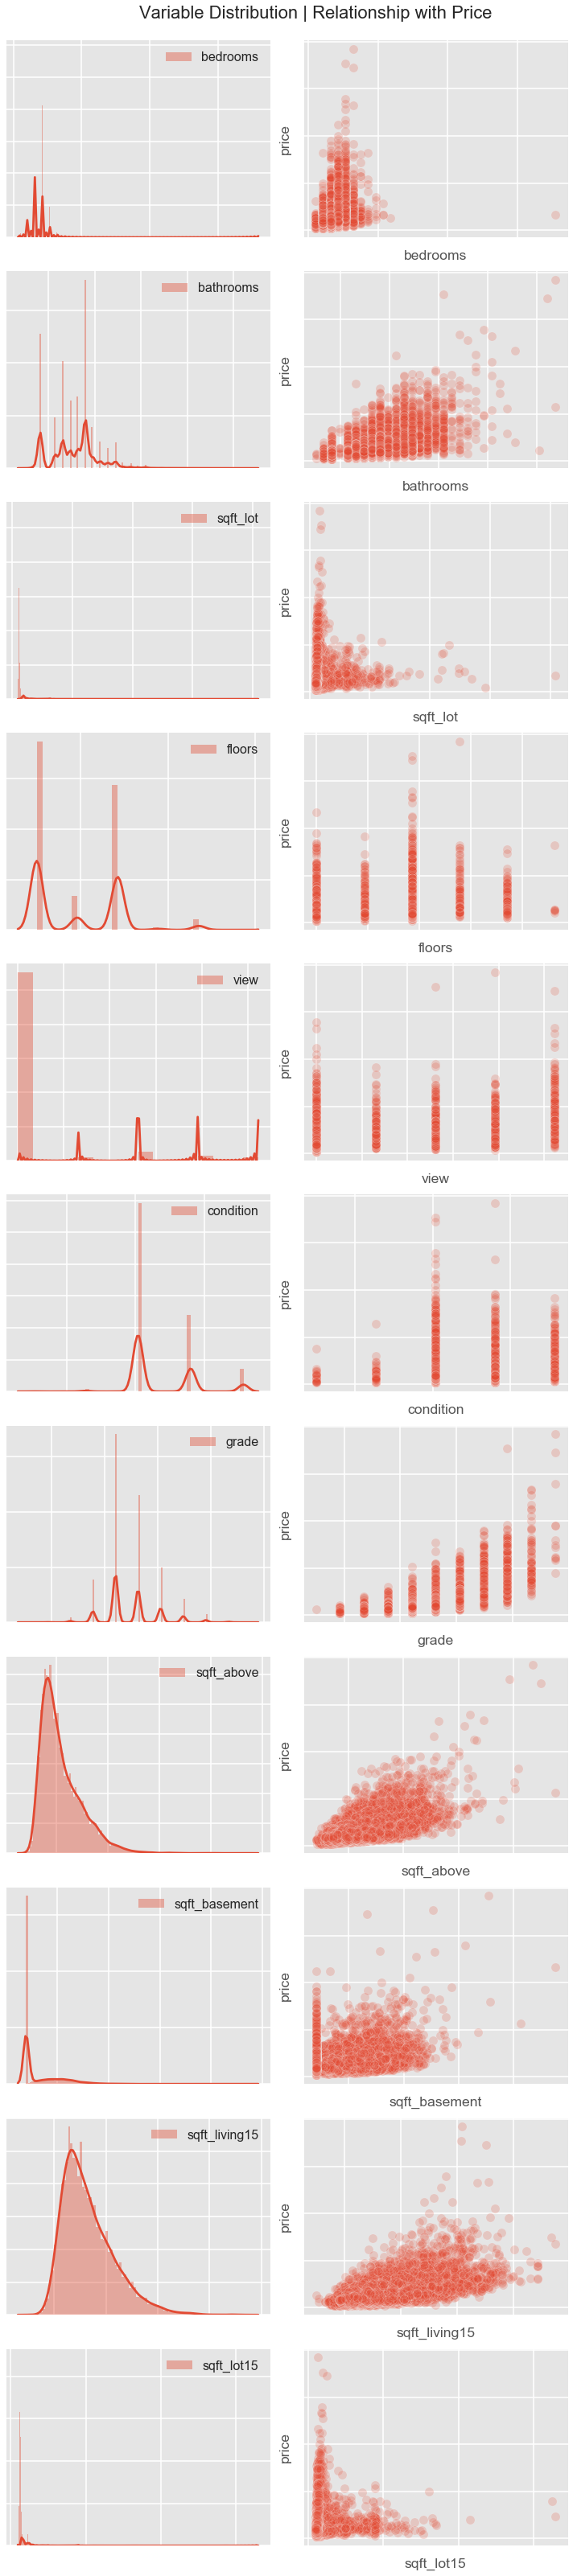

In [54]:
# Plot each distribution and relationship with the target.
n = len(numerical_cols) # For the figsize.

fig, ax_lst = plt.subplots(nrows=n, ncols=2, figsize=(10, n*4))
fig.suptitle('Variable Distribution | Relationship with Price', 
             x=0.55, y=1.01, # Centering the title.
             fontsize=22)

for (ax_left, ax_right), col in zip(ax_lst, numerical_cols):
    # Left and right plot.
    sns.distplot(normalized[col], bins='auto', label=col, ax=ax_left)
    sns.scatterplot(x=col, y='price', alpha=0.2, data=normalized, ax=ax_right)
    
    # Remove top and right spines. Remove tick tables for tidyness.
    for ax in (ax_left, ax_right):
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    ax_left.set(xlabel='')
    ax_right.set(xlabel=col)
    
    # Label plot with a legend.
    ax_left.legend()
    
fig.tight_layout()

**Columns I want to investigate.**
```python
['bedrooms', 'bathrooms', 'sqft_above', 'sqft_lot',
 'floors', 'view', 'condition', 'grade', 'sqft_basement']
```

***`price`***

*Price (our target variable) is badly skewed and probably will normalize quite a lot with a simple log-transformation.*

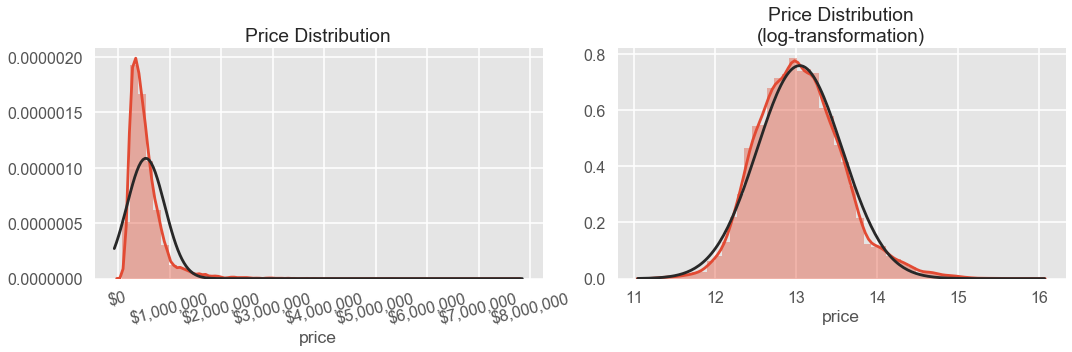

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

sns.distplot(normalized['price'], fit=stats.norm, ax=ax1)
ax1.set(title='Price Distribution')
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
for tick in ax1.get_xticklabels():
    tick.set_rotation(15)

sns.distplot(np.log(normalized['price']), fit=stats.norm, ax=ax2)
ax2.set(title='Price Distribution\n(log-transformation)')

fig.tight_layout()

*The transformation is definitely worthwhile to implement.*

*First however, I'm going to attempt to remove the outliers from the original data.*

In [56]:
# Check the amount of homes with a z-score greater than 3.
price_z_abs = np.abs(stats.zscore(normalized['price']))

num_outlier = (price_z_abs > 3).sum()
percent = (num_outlier / len(price_z_abs)) * 100

print(f'Percent price outliers: {round(percent, 2)}%.')
print(f'({num_outlier}/{len(price_z_abs)})')

Percent price outliers: 1.88%.
(406/21597)


*$1.88\%$ is an acceptable loss of data.*

In [57]:
# Set the dataframe to remove the outliers.
normalized = normalized[price_z_abs <= 3]
normalized

,price,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,...,decade_built_1920,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010
0,221900,3.15918,1.650223,1.123878,1.000000,1.0,4.074414,4.409558,1.978567,1.000000,...,0,0,0,1,0,0,0,0,0,0
1,538000,3.15918,3.275782,1.162321,2.852983,1.0,4.074414,4.409558,3.174594,1.903633,...,0,0,0,1,0,0,0,0,0,0
2,180000,2.07959,1.650223,1.228921,1.000000,1.0,4.074414,3.557169,1.483243,1.000000,...,0,1,0,0,0,0,0,0,0,0
3,604000,4.23877,4.251117,1.108182,1.000000,1.0,7.148827,4.409558,1.821513,3.055765,...,0,0,0,0,1,0,0,0,0,0
4,510000,3.15918,2.950670,1.182557,1.000000,1.0,4.074414,5.261948,2.582621,1.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000,3.15918,3.600894,1.014754,4.705966,1.0,4.074414,5.261948,2.401405,1.000000,...,0,0,0,0,0,0,0,0,1,0
21593,400000,4.23877,3.600894,1.127814,2.852983,1.0,4.074414,5.261948,3.343729,1.000000,...,0,0,0,0,0,0,0,0,0,1
21594,402101,2.07959,1.325112,1.020043,2.852983,1.0,4.074414,4.409558,1.785270,1.000000,...,0,0,0,0,0,0,0,0,1,0
21595,400000,3.15918,3.600894,1.045108,2.852983,1.0,4.074414,5.261948,2.485973,1.000000,...,0,0,0,0,0,0,0,0,1,0


In [58]:
# Log-transformation.
normalized['log_price'] = np.log(normalized['price'])
normalized.drop('price', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,sqft_living15,...,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,log_price
0,3.15918,1.650223,1.123878,1.000000,1.0,4.074414,4.409558,1.978567,1.000000,2.373292,...,0,0,1,0,0,0,0,0,0,12.309982
1,3.15918,3.275782,1.162321,2.852983,1.0,4.074414,4.409558,3.174594,1.903633,2.884081,...,0,0,1,0,0,0,0,0,0,13.195614
2,2.07959,1.650223,1.228921,1.000000,1.0,4.074414,3.557169,1.483243,1.000000,4.387260,...,1,0,0,0,0,0,0,0,0,12.100712
3,4.23877,4.251117,1.108182,1.000000,1.0,7.148827,4.409558,1.821513,3.055765,2.402480,...,0,0,0,1,0,0,0,0,0,13.311329
4,3.15918,2.950670,1.182557,1.000000,1.0,4.074414,5.261948,2.582621,1.000000,3.044615,...,0,0,0,0,0,1,0,0,0,13.142166


#### Quick joinplot view.

In [59]:
@interact
def jp(variable=list(normalized.columns)):
    sns.jointplot(x=variable, y='log_price', 
                  data=normalized, 
                  kind='reg');

interactive(children=(Dropdown(description='variable', options=('bedrooms', 'bathrooms', 'sqft_lot', 'floors',…

#### Q: How are each of the continuous columns related to `log_price` and how do outliers impact the relationship?

***`bedrooms`***

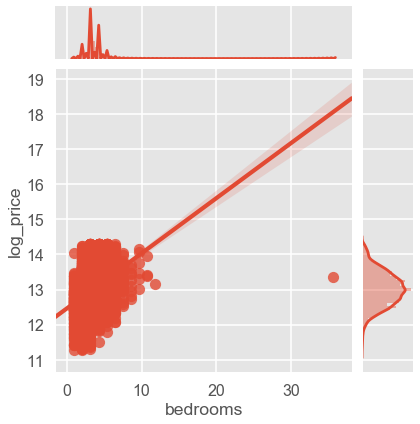

In [60]:
sns.jointplot(x='bedrooms', y='log_price', 
              data=normalized, kind='reg');

*Due to the extreme outlier, there doesn't seem to be much of a linear relationship here. Let's check without the outlier.*

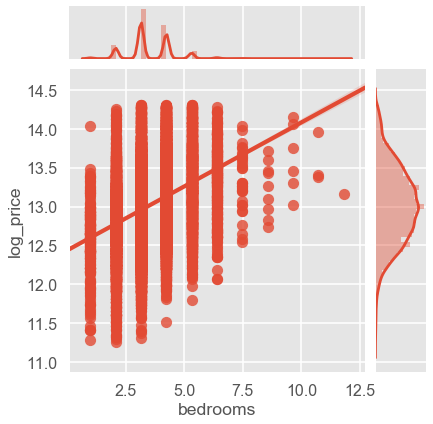

In [61]:
sns.jointplot(x='bedrooms', y='log_price', 
                  data=normalized[normalized['bedrooms'] < 30], 
                  kind='reg');

There seems to be a linear relationship now.

> There are still a lot of outliers (greater than 8 bedrooms) which I'll keep in mind in case I need to adjust the data in modeling.

It's definitely worth dropping this outlier considering how egregious it is.

In [62]:
# Drop the bedroom outlier.
print('Length before:\t', len(normalized))
normalized.drop(normalized[normalized['bedrooms'] > 30].index, 
                inplace=True)
print('Length after:\t', len(normalized))

Length before:	 21191
Length after:	 21190


***`bathrooms`***

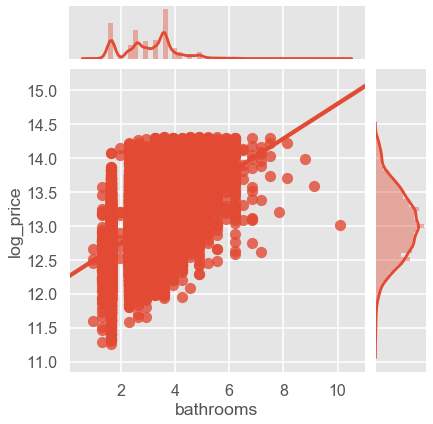

In [63]:
sns.jointplot(x='bathrooms', y='log_price', 
              data=normalized, kind='reg');

Also skewed to the right. I will need to consider the z-score for the upper values (same as bedrooms).

***`sqft_above`***

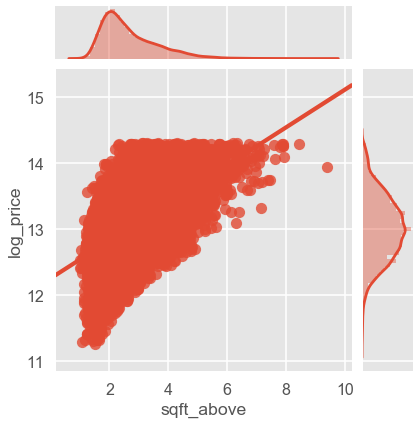

In [64]:
sns.jointplot(x='sqft_above', y='log_price', 
              data=normalized, kind='reg');

Very linear, but also very skewed again.

`sqft_living` might work well as a log-transformation.

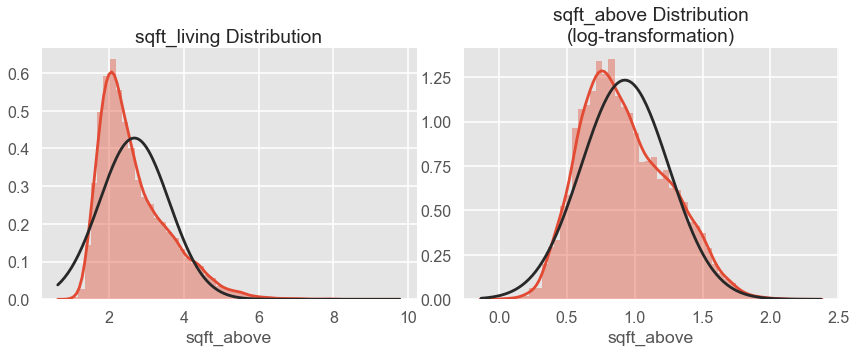

In [65]:
# Plot side-by-side sqft_living and log_sqft_living.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

sns.distplot(normalized['sqft_above'], fit=stats.norm, ax=ax1)
ax1.set(title='sqft_living Distribution')

sns.distplot(np.log(normalized['sqft_above']), fit=stats.norm, ax=ax2)
ax2.set(title='sqft_above Distribution\n(log-transformation)')

fig.tight_layout()

Looks good!

In [66]:
normalized['log_sqft_above'] = np.log(normalized['sqft_above'])
normalized.drop('sqft_above', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,sqft_basement,sqft_living15,sqft_lot15,...,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above
0,3.15918,1.650223,1.123878,1.000000,1.0,4.074414,4.409558,1.000000,2.373292,1.183289,...,0,1,0,0,0,0,0,0,12.309982,0.682373
1,3.15918,3.275782,1.162321,2.852983,1.0,4.074414,4.409558,1.903633,2.884081,1.256216,...,0,1,0,0,0,0,0,0,13.195614,1.155180
2,2.07959,1.650223,1.228921,1.000000,1.0,4.074414,3.557169,1.000000,4.387260,1.271726,...,0,0,0,0,0,0,0,0,12.100712,0.394231
3,4.23877,4.251117,1.108182,1.000000,1.0,7.148827,4.409558,3.055765,2.402480,1.159457,...,0,0,1,0,0,0,0,0,13.311329,0.599668
4,3.15918,2.950670,1.182557,1.000000,1.0,4.074414,5.261948,1.000000,3.044615,1.251230,...,0,0,0,0,1,0,0,0,13.142166,0.948805


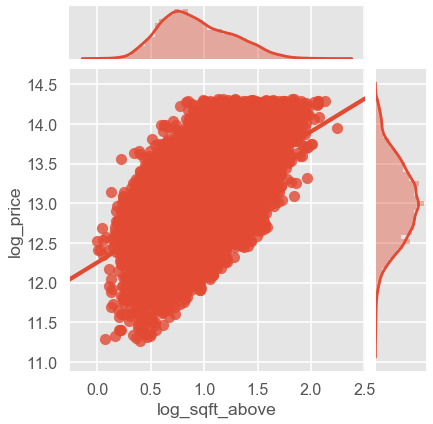

In [67]:
sns.jointplot(x='log_sqft_above', y='log_price', 
              data=normalized, kind='reg');

This now look very linear and correlated.

***`sqft_lot`***

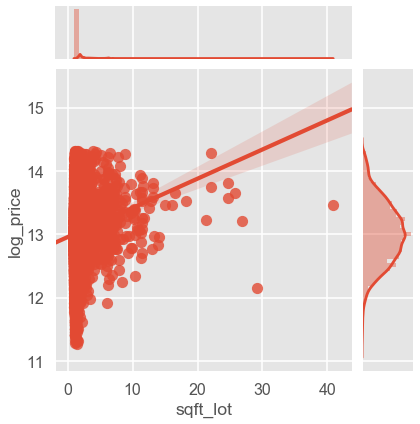

In [68]:
sns.jointplot(x='sqft_lot', y='log_price', 
              data=normalized, kind='reg');

The max of `sqft_lot` is almost 40 standard deviations from the mean!

Skewed very very badly. Let's check the original values of this column.

In [69]:
df['sqft_lot'].median()

7618.0

In [70]:
# Percent above 8000 sqft.
round(((df['sqft_lot'] > 8000).sum() / len(df)) * 100, 2)

45.61

To solve the drastic skewing problem, I'm going to make a boolean *categorical* - **8k_sqft_lot**.

In [71]:
# Create column `8k_sqft_lot` and drop `sqft_lot`.
normalized['_8k_sqft_lot'] = (df['sqft_lot'] >= 8000).astype('category')
normalized.drop('sqft_lot', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,floors,view,condition,grade,sqft_basement,sqft_living15,sqft_lot15,waterfront_1.0,...,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot
0,3.15918,1.650223,1.000000,1.0,4.074414,4.409558,1.000000,2.373292,1.183289,0,...,1,0,0,0,0,0,0,12.309982,0.682373,False
1,3.15918,3.275782,2.852983,1.0,4.074414,4.409558,1.903633,2.884081,1.256216,0,...,1,0,0,0,0,0,0,13.195614,1.155180,False
2,2.07959,1.650223,1.000000,1.0,4.074414,3.557169,1.000000,4.387260,1.271726,0,...,0,0,0,0,0,0,0,12.100712,0.394231,True
3,4.23877,4.251117,1.000000,1.0,7.148827,4.409558,3.055765,2.402480,1.159457,0,...,0,1,0,0,0,0,0,13.311329,0.599668,False
4,3.15918,2.950670,1.000000,1.0,4.074414,5.261948,1.000000,3.044615,1.251230,0,...,0,0,0,1,0,0,0,13.142166,0.948805,True


I don't need to one-hot-encode this column because the counterpart column (`less_than_8k_lot`) does not exist.

***`floors`***

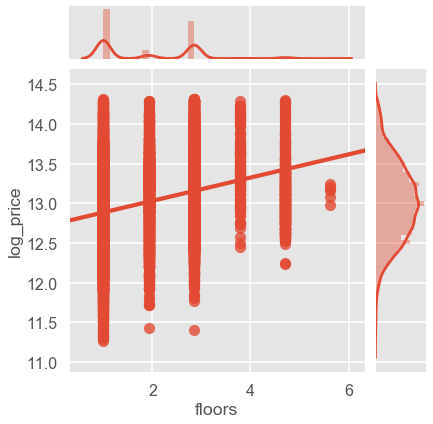

In [72]:
sns.jointplot(x='floors', y='log_price', 
              data=normalized, kind='reg');

Somewhat skewed to the right also, but much less drastic.

***`view`***

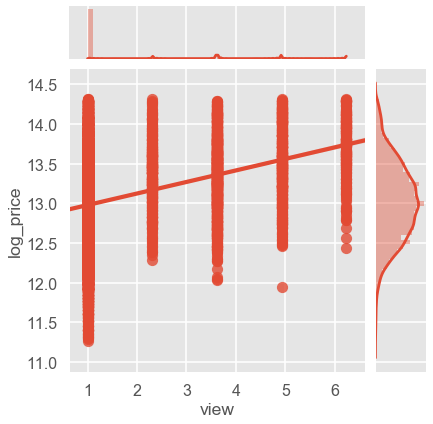

In [73]:
sns.jointplot(x='view', y='log_price', 
              data=normalized, kind='reg');

This column seems like it should be changed to a boolean category as well - whether or not a house has been viewed.

In [74]:
normalized['has_been_viewed'] = (df['view'] > 0).astype('category')
normalized.drop('view', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,floors,condition,grade,sqft_basement,sqft_living15,sqft_lot15,waterfront_1.0,zipcode_98002,...,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed
0,3.15918,1.650223,1.000000,4.074414,4.409558,1.000000,2.373292,1.183289,0,0,...,0,0,0,0,0,0,12.309982,0.682373,False,False
1,3.15918,3.275782,2.852983,4.074414,4.409558,1.903633,2.884081,1.256216,0,0,...,0,0,0,0,0,0,13.195614,1.155180,False,False
2,2.07959,1.650223,1.000000,4.074414,3.557169,1.000000,4.387260,1.271726,0,0,...,0,0,0,0,0,0,12.100712,0.394231,True,False
3,4.23877,4.251117,1.000000,7.148827,4.409558,3.055765,2.402480,1.159457,0,0,...,1,0,0,0,0,0,13.311329,0.599668,False,False
4,3.15918,2.950670,1.000000,4.074414,5.261948,1.000000,3.044615,1.251230,0,0,...,0,0,1,0,0,0,13.142166,0.948805,True,False


***`condition`***

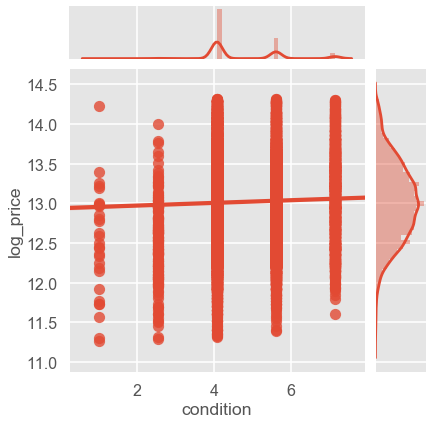

In [75]:
sns.jointplot(x='condition', y='log_price', 
              data=normalized, kind='reg');

Skewed to the left (for the first time!). That means there are more houses of poorer condition than of good condition.

Nevertheless, there isn't a linear relationship here.

***`grade`***

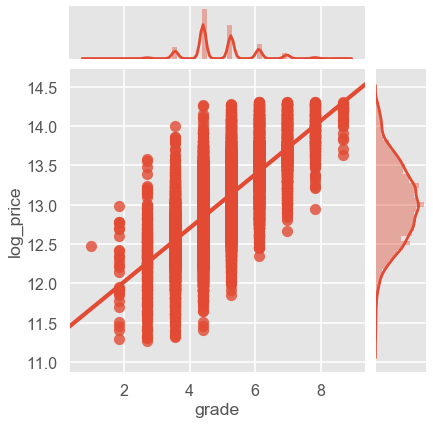

In [76]:
sns.jointplot(x='grade', y='log_price', 
              data=normalized, kind='reg');

This relationship looks highly correlated and the distribution of `grade` looks workable.

***`sqft_basement`***

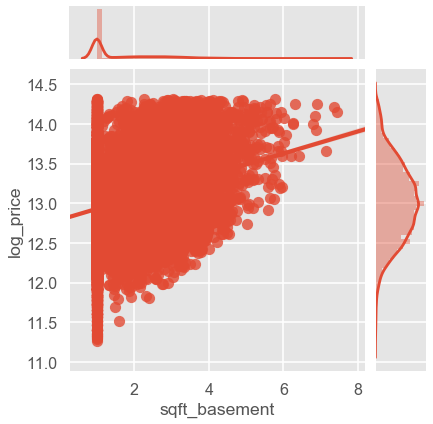

In [77]:
sns.jointplot(x='sqft_basement', y='log_price', 
              data=normalized, kind='reg');

Again, massively skewed to the right with many values at the minimum. 

This looks like a chance to create a boolean category.

In [78]:
normalized['has_basement'] = (df['sqft_basement'] > 0).astype('category')
normalized.drop('sqft_basement', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,floors,condition,grade,sqft_living15,sqft_lot15,waterfront_1.0,zipcode_98002,zipcode_98003,...,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed,has_basement
0,3.15918,1.650223,1.000000,4.074414,4.409558,2.373292,1.183289,0,0,0,...,0,0,0,0,0,12.309982,0.682373,False,False,False
1,3.15918,3.275782,2.852983,4.074414,4.409558,2.884081,1.256216,0,0,0,...,0,0,0,0,0,13.195614,1.155180,False,False,True
2,2.07959,1.650223,1.000000,4.074414,3.557169,4.387260,1.271726,0,0,0,...,0,0,0,0,0,12.100712,0.394231,True,False,False
3,4.23877,4.251117,1.000000,7.148827,4.409558,2.402480,1.159457,0,0,0,...,0,0,0,0,0,13.311329,0.599668,False,False,True
4,3.15918,2.950670,1.000000,4.074414,5.261948,3.044615,1.251230,0,0,0,...,0,1,0,0,0,13.142166,0.948805,True,False,False


***`sqft_living15`***

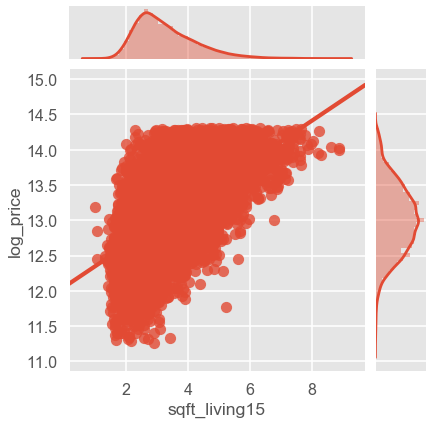

In [79]:
sns.jointplot(x='sqft_living15', y='log_price', 
              data=normalized, kind='reg');

Skewed gently to the right and linear. I'm going to see the log-transformation in action again.

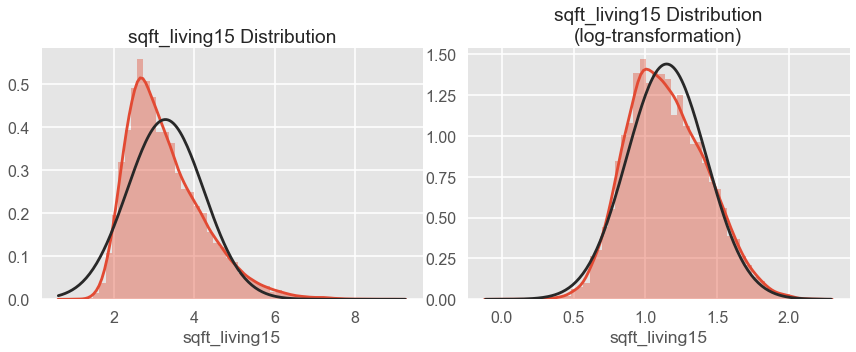

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

sns.distplot(normalized['sqft_living15'], fit=stats.norm, ax=ax1)
ax1.set(title='sqft_living15 Distribution')

sns.distplot(np.log(normalized['sqft_living15']), fit=stats.norm, ax=ax2)
ax2.set(title='sqft_living15 Distribution\n(log-transformation)')

fig.tight_layout()

Still skewed, but much better.

In [81]:
normalized['log_sqft_living15_nearest'] = np.log(normalized['sqft_living15'])
normalized.drop('sqft_living15', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,floors,condition,grade,sqft_lot15,waterfront_1.0,zipcode_98002,zipcode_98003,zipcode_98004,...,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed,has_basement,log_sqft_living15_nearest
0,3.15918,1.650223,1.000000,4.074414,4.409558,1.183289,0,0,0,0,...,0,0,0,0,12.309982,0.682373,False,False,False,0.864278
1,3.15918,3.275782,2.852983,4.074414,4.409558,1.256216,0,0,0,0,...,0,0,0,0,13.195614,1.155180,False,False,True,1.059206
2,2.07959,1.650223,1.000000,4.074414,3.557169,1.271726,0,0,0,0,...,0,0,0,0,12.100712,0.394231,True,False,False,1.478705
3,4.23877,4.251117,1.000000,7.148827,4.409558,1.159457,0,0,0,0,...,0,0,0,0,13.311329,0.599668,False,False,True,0.876502
4,3.15918,2.950670,1.000000,4.074414,5.261948,1.251230,0,0,0,0,...,1,0,0,0,13.142166,0.948805,True,False,False,1.113374


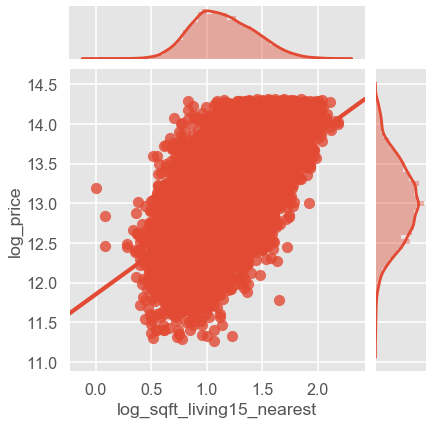

In [82]:
sns.jointplot(x='log_sqft_living15_nearest', y='log_price', 
              data=normalized, kind='reg');

***`sqft_lot15`***

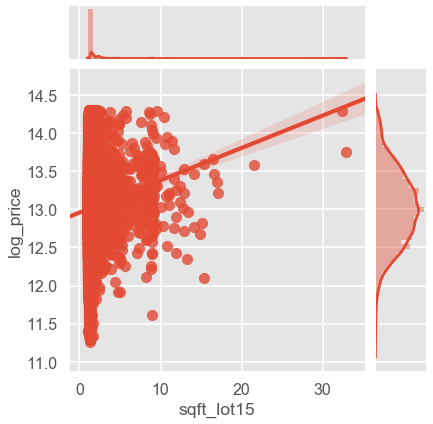

In [83]:
sns.jointplot(x='sqft_lot15', y='log_price', 
              data=normalized, kind='reg');

Same issue with the `sqft_lot` variable. Many minimum values and very heavily skewed.

In [84]:
df['sqft_lot15'].median()

7620.0

In [85]:
# Create column `8k_sqft_lot15` and drop `sqft_lot15`.
normalized['_8k_sqft_lot15_nearest'] = (df['sqft_lot15'] >= 8000).astype('category')
normalized.drop('sqft_lot15', axis=1, inplace=True)
normalized.head()

,bedrooms,bathrooms,floors,condition,grade,waterfront_1.0,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,...,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed,has_basement,log_sqft_living15_nearest,_8k_sqft_lot15_nearest
0,3.15918,1.650223,1.000000,4.074414,4.409558,0,0,0,0,0,...,0,0,0,12.309982,0.682373,False,False,False,0.864278,False
1,3.15918,3.275782,2.852983,4.074414,4.409558,0,0,0,0,0,...,0,0,0,13.195614,1.155180,False,False,True,1.059206,False
2,2.07959,1.650223,1.000000,4.074414,3.557169,0,0,0,0,0,...,0,0,0,12.100712,0.394231,True,False,False,1.478705,True
3,4.23877,4.251117,1.000000,7.148827,4.409558,0,0,0,0,0,...,0,0,0,13.311329,0.599668,False,False,True,0.876502,False
4,3.15918,2.950670,1.000000,4.074414,5.261948,0,0,0,0,0,...,0,0,0,13.142166,0.948805,True,False,False,1.113374,False


### Categorical

In [86]:
one_hot_categoricals = [x for x in df.columns if 
                        x not in numerical_cols and x != 'price']
new_cats = list(normalized.select_dtypes('category').columns)
cat_variables = one_hot_categoricals + new_cats
cat_variables

['waterfront',
 'zipcode',
 'renovated',
 'decade_built',
 '_8k_sqft_lot',
 'has_been_viewed',
 'has_basement',
 '_8k_sqft_lot15_nearest']

#### Q: Do any categorical variables show a distinct relationship to `price`?

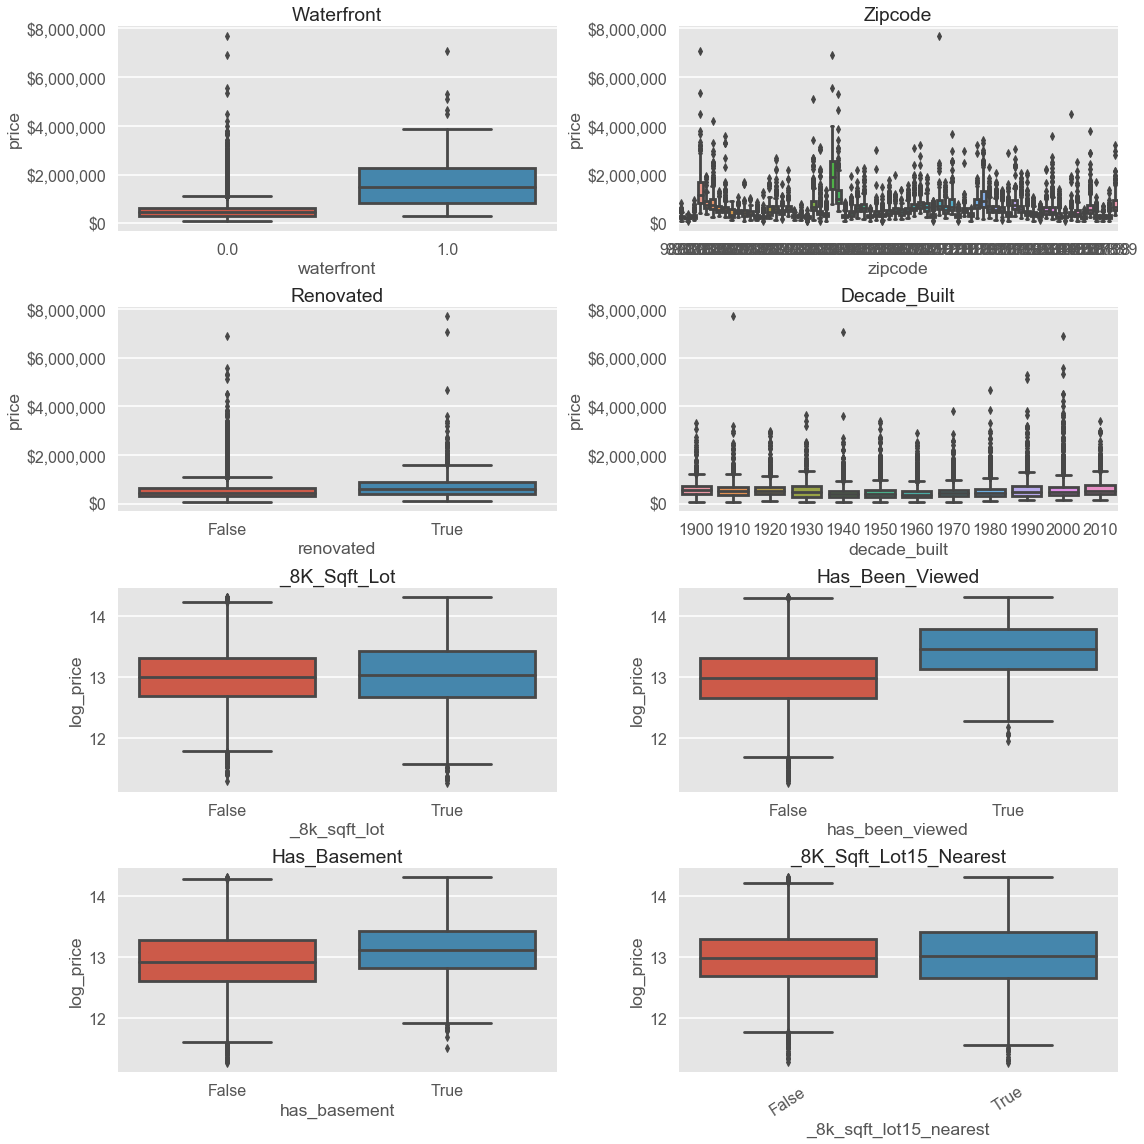

In [87]:
fig, ax_lst = plt.subplots(nrows=4, ncols=2, figsize=(16,16))

for col, ax in zip(cat_variables, ax_lst.flatten()):
    if col in normalized.columns:
        sns.boxplot(x=col, y='log_price', data=normalized, ax=ax)
    else:
        sns.boxplot(x=col, y='price', data=df, ax=ax)
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set(title=col.title())
plt.xticks(rotation=33)
fig.tight_layout()

There doesn't seem to be much of a correlation from one category to another. 

There are definitely some noticeable  differences in certain **zip codes** and the mean of **waterfront properties**.

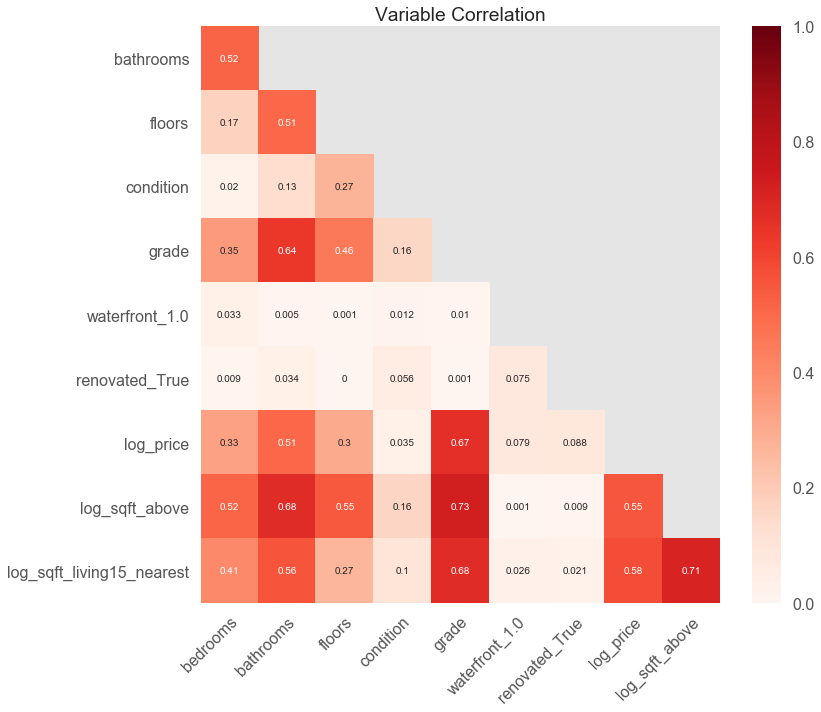

In [88]:
# Heatmap.
fig, ax = plt.subplots(figsize=(12,10))

corr = normalized[
    [c for c in normalized.columns 
     if not c.startswith('zipcode') and not c.startswith('decade')]
                 ].corr().abs().round(3)

# Set a 'mask' for the upper half of the heatmap.
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Reds', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Variable Correlation')

# Hack to fix the cutoff squares and remove empty row and column.
ax.set_ylim(len(corr), 1)
ax.set_xlim(xmax=len(corr)-1)

fig.tight_layout()

## Model 1

My first goal is to make a model which performs well in predictions. I'll make a simple model with the log-transformed categories (and not worry as much about multicollinearity) and move on to a more interpretable model next.

In [89]:
model_df = normalized.copy()

In [90]:
# Fix column names for modeling purposes.
model_df.columns = list(map(lambda x: x.replace('.', '_'), 
                              list(model_df.columns)))

In [91]:
# Replace True and False with 1 and 0.
for col in ['_8k_sqft_lot', 'has_been_viewed', 
            'has_basement', '_8k_sqft_lot15_nearest']:
    model_df[col] = model_df[col].replace({True: 1, False: 0})
model_df.head()

,bedrooms,bathrooms,floors,condition,grade,waterfront_1_0,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,...,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed,has_basement,log_sqft_living15_nearest,_8k_sqft_lot15_nearest
0,3.15918,1.650223,1.000000,4.074414,4.409558,0,0,0,0,0,...,0,0,0,12.309982,0.682373,0,0,0,0.864278,0
1,3.15918,3.275782,2.852983,4.074414,4.409558,0,0,0,0,0,...,0,0,0,13.195614,1.155180,0,0,1,1.059206,0
2,2.07959,1.650223,1.000000,4.074414,3.557169,0,0,0,0,0,...,0,0,0,12.100712,0.394231,1,0,0,1.478705,1
3,4.23877,4.251117,1.000000,7.148827,4.409558,0,0,0,0,0,...,0,0,0,13.311329,0.599668,0,0,1,0.876502,0
4,3.15918,2.950670,1.000000,4.074414,5.261948,0,0,0,0,0,...,0,0,0,13.142166,0.948805,1,0,0,1.113374,0


In [92]:
# Train / test split.
train, test = train_test_split(model_df, test_size=0.2, random_state=51)

In [93]:
len(train), len(test)

(16952, 4238)

In [94]:
print('Train:')
display(train.head())
print('Test:')
display(test.head())

Train:


,bedrooms,bathrooms,floors,condition,grade,waterfront_1_0,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,...,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed,has_basement,log_sqft_living15_nearest,_8k_sqft_lot15_nearest
10716,3.159180,2.625558,1.000000,4.074414,5.261948,0,0,0,0,0,...,0,0,0,12.793859,0.871011,0,0,1,1.182808,0
9677,3.159180,2.625558,1.000000,7.148827,4.409558,0,0,0,0,0,...,0,0,0,12.598115,0.538120,1,0,1,1.127652,1
9094,3.159180,3.600894,4.705966,5.611620,5.261948,0,0,0,0,0,...,0,0,0,13.437174,1.420957,1,0,1,1.151004,0
14182,4.238770,2.300447,1.000000,4.074414,4.409558,0,0,0,0,0,...,0,0,0,13.068118,0.619370,1,0,1,1.043909,1
7705,5.318361,3.926005,2.852983,4.074414,6.966727,0,0,0,0,0,...,0,1,0,13.560618,1.625981,1,1,0,1.603625,0


Test:


,bedrooms,bathrooms,floors,condition,grade,waterfront_1_0,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,...,decade_built_1990,decade_built_2000,decade_built_2010,log_price,log_sqft_above,_8k_sqft_lot,has_been_viewed,has_basement,log_sqft_living15_nearest,_8k_sqft_lot15_nearest
7657,3.15918,1.650223,1.926492,5.611620,3.557169,0,0,0,0,0,...,0,0,0,13.049793,0.632292,1,0,0,0.704600,1
4036,3.15918,3.600894,2.852983,4.074414,5.261948,0,0,0,0,0,...,0,0,0,13.335861,1.104442,0,0,0,1.276645,0
3843,3.15918,2.950670,1.000000,5.611620,5.261948,0,0,0,0,0,...,0,0,0,13.142166,0.559060,1,0,1,1.127652,1
8262,3.15918,2.625558,1.000000,5.611620,4.409558,0,0,0,0,0,...,0,0,0,12.154779,0.735870,0,0,0,1.127652,0
1490,3.15918,2.625558,1.000000,4.074414,5.261948,0,0,0,0,0,...,0,0,0,13.163505,0.971925,1,0,0,1.280708,1


### Model 1 - Predictability

The model we were aiming towards has less to do with an interpretable result as a cleaner dataset. We used *log-transformation* on multiple columns and *normalization* on multiple columns. We will hopefully get results with a high r-squared but might have a more difficult time explaining these results.

In [95]:
# Fit the model.
model = get_model('log_price', train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1147.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:35:37   Log-Likelihood:                 5157.3
No. Observations:               16952   AIC:                        -1.013e+04
Df Residuals:                   16858   BIC:                            -9399.
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.0714      0.019    591.069      0.000      11.035      11.108
bedrooms                     -0.0026      0.002     -1.338      0.181      -0.006       0.001
bathrooms                     0.0280      0.003     10.799      0.000       0.023       0.033
floors                       -0.0408      0.002    -17.548      0.000      -0.045      -0.036
condition                     0.0405      0.002     25.435      0.000       0.037       0.044
grade                         0.1060      0.003     39.179      0.000       0.101       0.111
waterfront_1_0                0.5140      0.024     21.765      0.000       0.468       0.560
zipcode_98002                -0.0379      0.018     -2.098      0.036      -0.073      -0.002
zipcode_98003                 0.0161      0.016      1.002      0.316      -0.015       0.048
zipcode_98004                 1.0643      0.017     61.510      0.000       1.030       1.098
zipcode_98005                 0.7312      0.019     38.051      0.000       0.693       0.769
zipcode_98006                 0.6228      0.014     42.964      0.000       0.594       0.651
zipcode_98007                 0.6507      0.020     32.580      0.000       0.612       0.690
zipcode_98008                 0.6506      0.016     39.638      0.000       0.618       0.683
zipcode_98010                 0.2702      0.022     12.009      0.000       0.226       0.314
zipcode_98011                 0.4409      0.018     24.697      0.000       0.406       0.476
zipcode_98014                 0.3686      0.021     17.567      0.000       0.328       0.410
zipcode_98019                 0.3319      0.018     18.244      0.000       0.296       0.368
zipcode_98022                 0.0593      0.017      3.415      0.001       0.025       0.093
zipcode_98023                -0.0267      0.014     -1.898      0.058      -0.054       0.001
zipcode_98024                 0.4666      0.025     18.495      0.000       0.417       0.516
zipcode_98027                 0.5065      0.015     34.366      0.000       0.478       0.535
zipcode_98028                 0.4124      0.016     25.343      0.000       0.380       0.444
zipcode_98029                 0.5817      0.016     36.631      0.000       0.551       0.613
zipcode_98030                 0.0446      0.017      2.681      0.007       0.012       0.077
zipcode_98031                 0.0760      0.016      4.655      0.000       0.044       0.108
zipcode_98032                -0.0057      0.021     -0.276      0.782      -0.046       0.035
zipcode_98033                 0.7611      0.015     52.248      0.000       0.733       0.790
zipcode_98034                 0.5381      0.014     38.444      0.000       0.511       0.566
zipcode_98038                 0.1674      0.014     12.169      0.000      

In [96]:
table = get_data_table(model)
table.head()

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
bedrooms,-0.0026,0.002,-1.338,0.181,-0.006,0.001
bathrooms,0.0280,0.003,10.799,0.000,0.023,0.033
floors,-0.0408,0.002,-17.548,0.000,-0.045,-0.036
condition,0.0405,0.002,25.435,0.000,0.037,0.044
grade,0.1060,0.003,39.179,0.000,0.101,0.111


In [97]:
# Remove features with too-high p-values and refit the model.
low_p_vals = list(table[table['P>|t|'] < 0.05].index)

removing = list(set(table.index) - set(low_p_vals))
removing

['zipcode_98023',
 'decade_built_2010',
 'bedrooms',
 'decade_built_1930',
 'decade_built_1910',
 'zipcode_98032',
 '_8k_sqft_lot15_nearest',
 'zipcode_98092',
 'zipcode_98003']

Since removing the categorical `zipcode` and `decade_built` columns would mess up the intercept, I'll only remove the other two insignificant columns: `['bedrooms', '_8k_sqft_lot15_nearest']`

#### Revision

In [98]:
predictors = sorted(list(
    set(train.columns) - set(['bedrooms', 
                              '_8k_sqft_lot15_nearest', 
                              'log_price'])
    ))

In [99]:
model = get_model('log_price', train, predictors=predictors)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1173.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:35:37   Log-Likelihood:                 5156.4
No. Observations:               16952   AIC:                        -1.013e+04
Df Residuals:                   16860   BIC:                            -9417.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.0666      0.018    601.998      0.000      11.031      11.103
_8k_sqft_lot                  0.0220      0.004      5.959      0.000       0.015       0.029
bathrooms                     0.0272      0.003     10.801      0.000       0.022       0.032
condition                     0.0405      0.002     25.428      0.000       0.037       0.044
decade_built_1910            -0.0026      0.011     -0.241      0.810      -0.024       0.019
decade_built_1920             0.0207      0.010      2.057      0.040       0.001       0.040
decade_built_1930            -0.0093      0.012     -0.764      0.445      -0.033       0.015
decade_built_1940            -0.0221      0.010     -2.225      0.026      -0.042      -0.003
decade_built_1950            -0.0606      0.010     -6.226      0.000      -0.080      -0.041
decade_built_1960            -0.0877      0.010     -8.854      0.000      -0.107      -0.068
decade_built_1970            -0.0951      0.010     -9.346      0.000      -0.115      -0.075
decade_built_1980            -0.0558      0.010     -5.379      0.000      -0.076      -0.035
decade_built_1990            -0.0506      0.011     -4.717      0.000      -0.072      -0.030
decade_built_2000            -0.0512      0.010     -4.934      0.000      -0.072      -0.031
decade_built_2010             0.0100      0.011      0.871      0.384      -0.012       0.032
floors                       -0.0408      0.002    -17.537      0.000      -0.045      -0.036
grade                         0.1064      0.003     39.756      0.000       0.101       0.112
has_basement                  0.1116      0.004     29.178      0.000       0.104       0.119
has_been_viewed               0.1384      0.005     25.579      0.000       0.128       0.149
log_sqft_above                0.5504      0.009     58.336      0.000       0.532       0.569
log_sqft_living15_nearest     0.2098      0.009     24.356      0.000       0.193       0.227
renovated_True                0.0813      0.008      9.865      0.000       0.065       0.097
waterfront_1_0                0.5148      0.024     21.824      0.000       0.469       0.561
zipcode_98002                -0.0378      0.018     -2.093      0.036      -0.073      -0.002
zipcode_98003                 0.0164      0.016      1.022      0.307      -0.015       0.048
zipcode_98004                 1.0643      0.017     61.533      0.000       1.030       1.098
zipcode_98005                 0.7314      0.019     38.067      0.000       0.694       0.769
zipcode_98006                 0.6226      0.014     42.978      0.000       0.594       0.651
zipcode_98007                 0.6501      0.020     32.559      0.000       0.611       0.689
zipcode_98008                 0.6502      0.016     39.624      0.000      

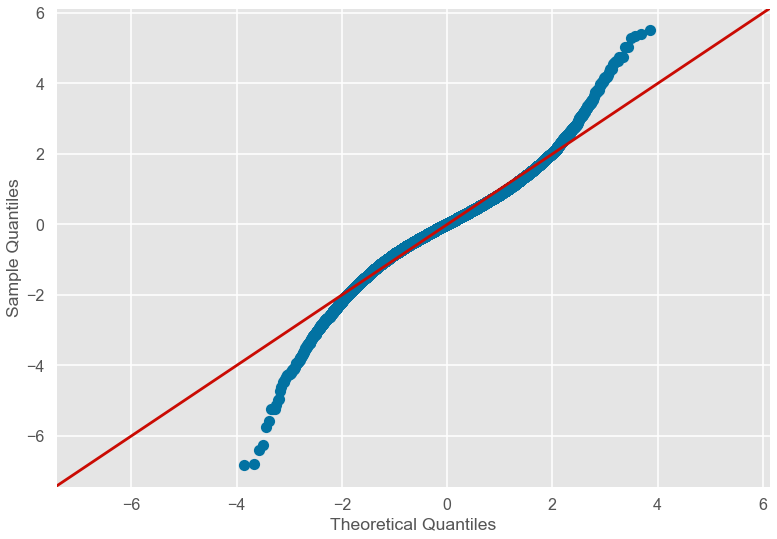

In [100]:
# Check the Normality assumption.
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True);

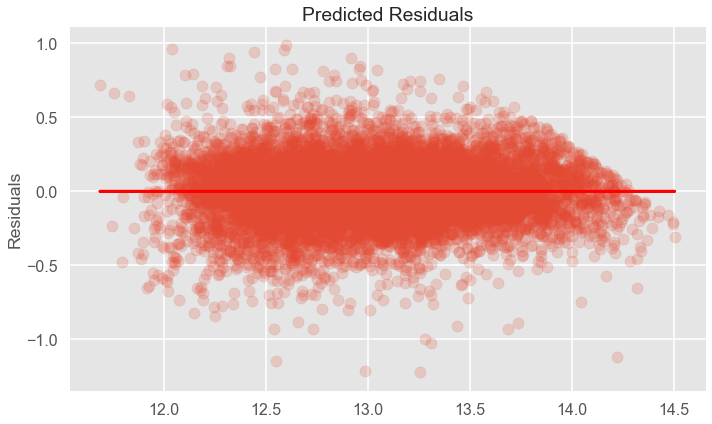

In [101]:
# Check for homescedasticity.
fig, ax = plt.subplots(figsize=(10,6))

# Plot residuals.
ax.scatter(model.predict(train[predictors]), 
           model.resid, alpha=0.2)

# Plot a reference line: y=0
ax.plot(model.predict(train[predictors]), 
        [0 for i in range(len(train))], 
        color='red')

ax.set(ylabel='Residuals')
ax.set(title='Predicted Residuals')
fig.tight_layout()

The model does not follow the normality assumption but is pretty good with its homeoscedasticity.

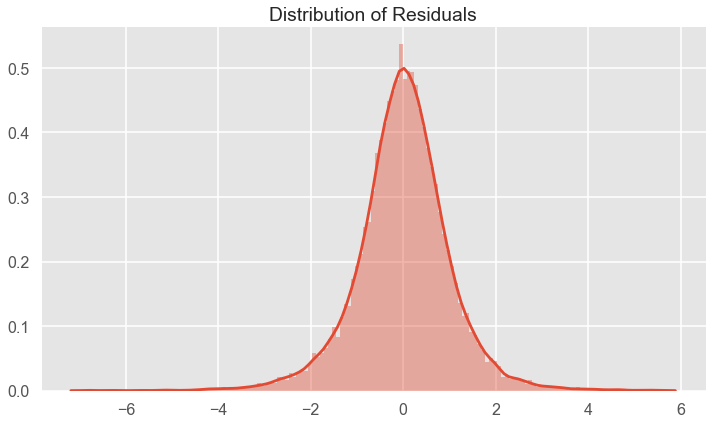

In [102]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(stats.zscore(model.resid), bins='auto', ax=ax)
ax.set(title='Distribution of Residuals')
fig.tight_layout()

The residuals are not bad, but certainly not perfectly distributed. The model tends to overestimate the prices of lower-end homes and underestimate higher-end homes.

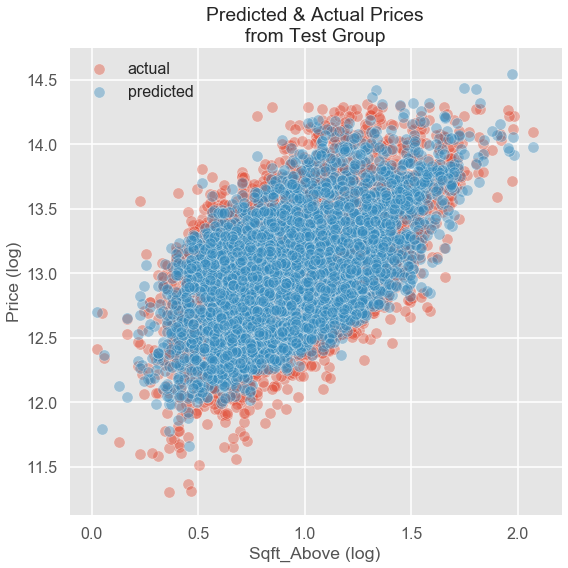

In [103]:
# Predictions.
predictions = model.predict(test)

x_vals = [x for x in range(len(predictions.index))]

fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='log_sqft_above', y='log_price', data=test, ax=ax, 
                alpha=0.4, label='actual')
sns.scatterplot(x=test['log_sqft_above'], y=predictions, ax=ax, 
                alpha=0.4, label='predicted')
ax.set(title='Predicted & Actual Prices\nfrom Test Group', 
       xlabel='Sqft_Above (log)', ylabel='Price (log)')
fig.tight_layout()

***Checking for multicollinearity - variance inflation factor***

In [104]:
X = sm.add_constant(train[predictors])

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_lst = sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)

In [105]:
vif_lst

[('const', 178.80117145611663),
 ('decade_built_2000', 7.763293136774729),
 ('decade_built_1990', 5.605911905789814),
 ('decade_built_1960', 5.584020048710295),
 ('decade_built_1980', 5.344350588665684),
 ('decade_built_1970', 5.250194132488081),
 ('decade_built_1950', 5.113247725720936),
 ('log_sqft_above', 4.973632892085289),
 ('decade_built_1940', 3.805947709200055),
 ('decade_built_2010', 3.779327330503246),
 ('grade', 3.3882591358426275),
 ('bathrooms', 3.1021302284968773),
 ('log_sqft_living15_nearest', 3.0112110218725854),
 ('zipcode_98103', 2.9826235417119924),
 ('zipcode_98115', 2.867178536893114),
 ('floors', 2.8669571559733082),
 ('zipcode_98117', 2.76557543082725),
 ('decade_built_1920', 2.764967986591029),
 ('zipcode_98052', 2.6597571722427373),
 ('zipcode_98038', 2.6392986510003364),
 ('zipcode_98118', 2.606964538944803),
 ('zipcode_98042', 2.5301143279671363),
 ('zipcode_98034', 2.5015363263497736),
 ('zipcode_98133', 2.4607087228121363),
 ('zipcode_98023', 2.41849634185

Let's explore the columns with slightly inflated VIF and see how it would impact the model by removing some / all of them.*

> Note: Without using `sm.add_constant()` to the dataframe which you're studying, the VIFs will not calculate properly with `variance_inflation_factor()`.
> 
> The following is an over-analysis for how to attempt to correct VIF issues by checking combinations of variables. **This is technically an automated way to deal with multicollinearity  and could be used rather than checking the correlation and heatmap.**

In [106]:
# Remove each variable from model and see how it affects the vif and r-squared.
def get_vif_df(x_cols,
               columns=['variables_removed', 'r_squared', 'high_vifs'], 
               rows = []):
    """
    Returns a VIF dataframe with each combination of variables of x_cols removed
    """
    for i in range(len(x_cols)):
        # Get combinations of length i to remove from the model.
        combos_lst = list(combinations(x_cols, i+1))
        
        # Remove each combo.
        for combo in combos_lst:
            print(combo)
            variables = list(set(low_p_vals) - set(combo))
            model = get_model('log_price', train, variables)
            
            # Get r-squared.
            r_squared = float(
                pd.DataFrame(
                    model.summary().tables[0].data
                    ).loc[0,3]
                )
            
            # Recalculate VIF.
            X = sm.add_constant(train[variables])
            vif = [variance_inflation_factor(X.values, i) 
                   for i in range(X.shape[1])]
            vif_lst = list(zip(X.columns, vif))
            high_vif = {k: v for (k, v) in vif_lst if v > 5}

            rows.append([sorted(list(combo)), r_squared, high_vif])
        print(i+1, 'complete.\n')

    return pd.DataFrame(rows, columns=columns)

In [107]:
if 'vif_df.csv' in os.listdir():
    vif_df = pd.read_csv('vif_df.csv', index_col=0)
else:
    # Get variables which have less than 5 vif.
    x_cols = [x[0] for x in vif_lst if x[1]>5 and x[0]!='const']
    vif_df = get_vif_df(x_cols)
    vif_df.to_csv('vif_df.csv')

vif_df.head()

,variables_removed,r_squared,high_vifs
0,['decade_built_2000'],0.863,{'const': 105.4748245817837}
1,['decade_built_1990'],0.863,{'const': 105.32466959238181}
2,['decade_built_1960'],0.862,{'const': 98.95007173404109}
3,['decade_built_1980'],0.863,{'const': 102.50329063484702}
4,['decade_built_1970'],0.861,{'const': 101.53360644893115}


In [108]:
vif_df['variables_removed'] = vif_df['variables_removed'].apply(lambda x: 
                                                                eval(x))
vif_df['high_vifs'] = vif_df['high_vifs'].apply(lambda x: 
                                                eval(x))
vif_df['num_high_vif'] = vif_df['high_vifs'].apply(lambda x: 
                                                   len(x))
vif_df['num_removed'] = vif_df['variables_removed'].apply(lambda x: 
                                                          len(x))
vif_df

,variables_removed,r_squared,high_vifs,num_high_vif,num_removed
0,[decade_built_2000],0.863,{'const': 105.4748245817837},1,1
1,[decade_built_1990],0.863,{'const': 105.32466959238181},1,1
2,[decade_built_1960],0.862,{'const': 98.95007173404109},1,1
3,[decade_built_1980],0.863,{'const': 102.50329063484702},1,1
4,[decade_built_1970],0.861,{'const': 101.53360644893115},1,1
...,...,...,...,...,...
58,"[decade_built_1950, decade_built_1960, decade_...",0.861,{'const': 96.47047356754845},1,5
59,"[decade_built_1950, decade_built_1970, decade_...",0.861,{'const': 97.50738551773945},1,5
60,"[decade_built_1950, decade_built_1960, decade_...",0.861,{'const': 96.30647366892713},1,5
61,"[decade_built_1950, decade_built_1960, decade_...",0.861,{'const': 96.24641074413667},1,5


In [109]:
vif_df['num_high_vif'].value_counts()

1    63
Name: num_high_vif, dtype: int64

We can see by this experiment that  the r-squared didn't change very much from when we removed one of these variables compared to all of these variables.

There doesn't seem to be much incentive to keep this categorical in the future models.

# Data Processing & Model 2

In [139]:
preprocessed = df.copy()
preprocessed.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,renovated,decade_built
0,221900,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0,98178,1340,5650,False,1950
1,538000,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400,98125,1690,7639,True,1950
2,180000,2,1.00,10000,1.0,0.0,0.0,3,6,770,0,98028,2720,8062,False,1930
3,604000,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910,98136,1360,5000,False,1960
4,510000,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0,98074,1800,7503,False,1980


In [140]:
preprocessed['renovated'] = preprocessed['renovated'].map(
    {True: 1.0, False: 0.0}
    )

preprocessed.drop('decade_built', axis=1, inplace=True)
preprocessed.drop('view', axis=1, inplace=True)

In [141]:
show_iqr_outliers(preprocessed)

Price:
5.36%	1158/21597

Bedrooms:
2.45%	530/21597

Bathrooms:
2.6%	561/21597

Sqft_Lot:
11.2%	2419/21597

Floors:
0.0%	0/21597

Condition:
0.13%	29/21597

Grade:
8.82%	1905/21597

Sqft_Above:
2.82%	610/21597

Sqft_Basement:
2.3%	496/21597

Sqft_Living15:
2.51%	543/21597

Sqft_Lot15:
10.13%	2188/21597



In [142]:
# See the total number or unique outliers.
master_idx_lst = []
for c in preprocessed.columns:
    master_idx_lst += list(get_iqr_outliers_index(preprocessed[c]))
    
total_idx = set(master_idx_lst)
print('Total:\t', len(total_idx))
print(f'\t {round((len(total_idx)/len(preprocessed))*100, 2)}%')

Total:	 4986
	 23.09%


In [143]:
def remove_all_iqr_outliers(column, df, all_outliers=True):
    """
    In:
        column: column name which you want to eliminate the IQR outliers.
        df: dataframe which you want to alter.
    
    Alters the given dataframe in place.
    """
    while True:
        # Get and drop the indexes of the IQR outliers.
        outlier_idx = get_iqr_outliers_index(df[column])
        df.drop(outlier_idx, inplace=True)
        print('Removing', len(outlier_idx))
        
        if not all_outliers:
            return
        # Check if there are more on a second pass.
        if all_outliers and len(get_iqr_outliers_index(df[column])) == 0:
            return

### Removing IQR outliers.

In [144]:
remove_all_iqr_outliers('price', preprocessed)

Removing 1158
Removing 259
Removing 17


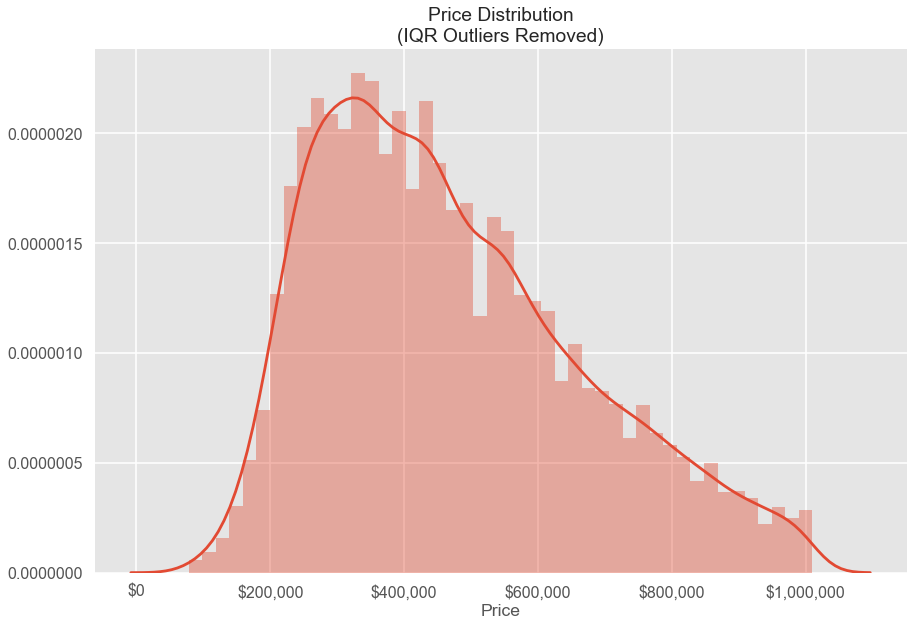

In [145]:
fig, ax = plt.subplots()
sns.distplot(preprocessed['price'], ax=ax)
ax.set(title='Price Distribution\n(IQR Outliers Removed)', xlabel='Price')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
fig.tight_layout()

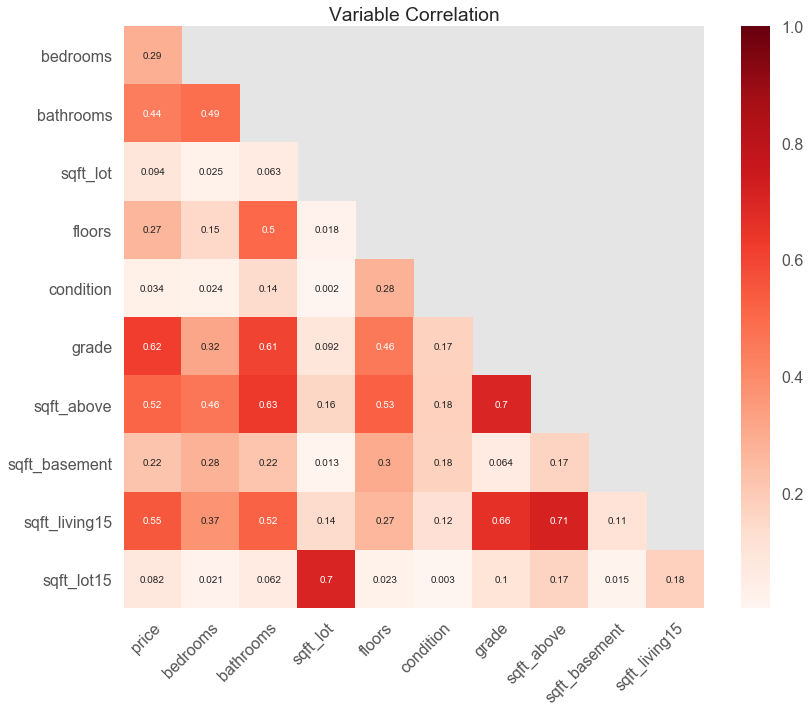

In [146]:
# Heatmap.
fig, ax = plt.subplots(figsize=(12,10))

# corr = df.drop('price', axis=1).corr().abs().round(3)
corr = preprocessed.corr().abs().round(3)

# Set a 'mask' for the upper half of the heatmap.
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Reds', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Variable Correlation')

# Hack to fix the cutoff squares and remove empty row and column.
ax.set_ylim(len(corr), 1)
ax.set_xlim(xmax=len(corr)-1)

fig.tight_layout()

In [147]:
subset = preprocessed.select_dtypes('number')
subset.head()

,price,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,221900,3,1.00,5650,1.0,3,7,1180,0,1340,5650
1,538000,3,2.25,7242,2.0,3,7,2170,400,1690,7639
2,180000,2,1.00,10000,1.0,3,6,770,0,2720,8062
3,604000,4,3.00,5000,1.0,5,7,1050,910,1360,5000
4,510000,3,2.00,8080,1.0,3,8,1680,0,1800,7503


### Check VIF.

In [148]:
# Test VIF for the above variables.
X = sm.add_constant(subset.drop('price', axis=1))

# X = subset.drop('price', axis=1)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_lst = sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)

vif_lst

[('const', 132.19825240572086),
 ('sqft_above', 4.437336265047434),
 ('bathrooms', 2.58997999110568),
 ('sqft_living15', 2.5693857776232725),
 ('grade', 2.538172116364137),
 ('sqft_lot15', 2.029693613450549),
 ('sqft_lot', 2.001529411633598),
 ('floors', 1.9494257276777047),
 ('sqft_basement', 1.8526673830482037),
 ('bedrooms', 1.643836249950159),
 ('condition', 1.1105083509835016)]

The variables seem reasonably correlated!

## Model 2 - Optimizing for Interpretability.

In [150]:
model_2_df = pd.get_dummies(model_2_df, drop_first=True)

model_2_df.columns = list(map(lambda x: x.replace('.', '_'), 
                              list(model_2_df.columns)))

In [151]:
model = get_model('price', model_2_df)

table = get_data_table(model)
low_p_vals = list(table[table['P>|t|'] < 0.05].index)
to_remove = list(set(model_2_df.columns) - set(low_p_vals) - set(['price']))
to_remove

['zipcode_98042',
 'sqft_lot15',
 'zipcode_98031',
 'zipcode_98002',
 'zipcode_98022',
 'zipcode_98032',
 'zipcode_98030',
 'zipcode_98003']

In [152]:
model_2_df.drop('sqft_lot15', axis=1, inplace=True)
model = get_model('price', model_2_df)

table = get_data_table(model)
low_p_vals = list(table[table['P>|t|'] < 0.05].index)
to_remove = list(set(model_2_df.columns) - set(low_p_vals) - set(['price']))
to_remove

['zipcode_98042',
 'zipcode_98031',
 'zipcode_98002',
 'zipcode_98022',
 'zipcode_98032',
 'zipcode_98030',
 'zipcode_98003']

In [153]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     1167.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:08:45   Log-Likelihood:            -2.5699e+05
No. Observations:               20163   AIC:                         5.141e+05
Df Residuals:                   20082   BIC:                         5.148e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.545e+05   8303.097    -42.695      0.000   -3.71e+05   -3.38e+05
bedrooms       -3097.4258    840.288     -3.686      0.000   -4744.459   -1450.393
bathrooms       6711.0774   1370.091      4.898      0.000    4025.587    9396.568
sqft_lot           0.3200      0.016     19.959      0.000       0.289       0.351
floors         -2.372e+04   1635.521    -14.504      0.000   -2.69e+04   -2.05e+04
condition       2.781e+04    988.283     28.142      0.000    2.59e+04    2.97e+04
grade           3.883e+04    966.275     40.183      0.000    3.69e+04    4.07e+04
sqft_above       111.1460      1.785     62.257      0.000     107.647     114.645
sqft_basement     68.3536      2.052     33.312      0.000      64.332      72.376
sqft_living15     44.4576      1.668     26.658      0.000      41.189      47.726
waterfront_1_0  2.629e+05   1.22e+04     21.496      0.000    2.39e+05    2.87e+05
zipcode_98002   8587.5120   7367.342      1.166      0.244   -5853.083     2.3e+04
zipcode_98003   -460.2711   6630.652     -0.069      0.945   -1.35e+04    1.25e+04
zipcode_98004   4.888e+05   8344.621     58.575      0.000    4.72e+05    5.05e+05
zipcode_98005   3.232e+05   8182.830     39.502      0.000    3.07e+05    3.39e+05
zipcode_98006   2.652e+05   6181.469     42.902      0.000    2.53e+05    2.77e+05
zipcode_98007     2.5e+05   8436.685     29.632      0.000    2.33e+05    2.67e+05
zipcode_98008   2.459e+05   6762.420     36.370      0.000    2.33e+05    2.59e+05
zipcode_98010   8.074e+04   9432.939      8.559      0.000    6.22e+04    9.92e+04
zipcode_98011   1.407e+05   7421.825     18.960      0.000    1.26e+05    1.55e+05
zipcode_98014   1.088e+05   8827.461     12.324      0.000    9.15e+04    1.26e+05
zipcode_98019    9.44e+04   7493.234     12.598      0.000    7.97e+04    1.09e+05
zipcode_98022   1.101e+04   7067.689      1.557      0.119   -2848.190    2.49e+04
zipcode_98023  -2.219e+04   5761.583     -3.851      0.000   -3.35e+04   -1.09e+04
zipcode_98024   1.494e+05   1.08e+04     13.847      0.000    1.28e+05    1.71e+05
zipcode_98027   1.873e+05   6119.544     30.608      0.000    1.75e+05    1.99e+05
zipcode_98028   1.353e+05   6633.597     20.397      0.000    1.22e+05    1.48e+05
zipcode_98029   2.274e+05   6505.688     34.957      0.000    2.15e+05     2.4e+05
zipcode_98030   2711.2718   6797.632      0.399      0.690   -1.06e+04     1.6e+04
zipcode_98031   7850.5253   6675.935      1.176      0.240   -5234.856    2.09e+04
zipcode_98032  -3079.0193   8644.334     -0.356      0.722      -2e+04    1.39e+04
zipcode_98033   3.107e+05   6279.327     49.481      0.000    2.98e+05    3.23e+05
zipcode_98034   1.866e+05   5702.297     32.717      0.000    1.75e+05    1.98e+05
zipcode_98038   3.368e+04   5589.389      6.025      0.000    2.27e+04    4.46e+04
zipcode_9803

### Revisions.

It doesn't make sense that as bedrooms and floors of the house increase the value of the home decreases.

I'm going to drop these columns and see how it affects the model.

In [154]:
model_2_df.drop(columns=['bedrooms', 'floors'], inplace=True)
model_2_df.head()

,price,bathrooms,sqft_lot,condition,grade,sqft_above,sqft_basement,sqft_living15,waterfront_1_0,zipcode_98002,...,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,renovated_1_0
0,221900,1.00,5650,3,7,1180,0,1340,0,0,...,0,0,0,0,0,1,0,0,0,0
1,538000,2.25,7242,3,7,2170,400,1690,0,0,...,0,0,0,0,0,0,0,0,0,1
2,180000,1.00,10000,3,6,770,0,2720,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000,3.00,5000,5,7,1050,910,1360,0,0,...,0,0,0,0,0,0,0,0,0,0
4,510000,2.00,8080,3,8,1680,0,1800,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
model = get_model('price', model_2_df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     1181.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:08:46   Log-Likelihood:            -2.5710e+05
No. Observations:               20163   AIC:                         5.144e+05
Df Residuals:                   20084   BIC:                         5.150e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.748e+05   7989.239    -46.908      0.000    -3.9e+05   -3.59e+05
bathrooms      -1338.8976   1261.197     -1.062      0.288   -3810.947    1133.152
sqft_lot           0.3375      0.016     21.004      0.000       0.306       0.369
condition       2.979e+04    981.297     30.356      0.000    2.79e+04    3.17e+04
grade           3.753e+04    953.951     39.341      0.000    3.57e+04    3.94e+04
sqft_above       104.3890      1.644     63.482      0.000     101.166     107.612
sqft_basement     76.4078      1.826     41.848      0.000      72.829      79.987
sqft_living15     47.0784      1.667     28.248      0.000      43.812      50.345
waterfront_1_0  2.602e+05   1.23e+04     21.176      0.000    2.36e+05    2.84e+05
zipcode_98002   8370.2091   7407.212      1.130      0.258   -6148.535    2.29e+04
zipcode_98003   1903.0546   6664.631      0.286      0.775   -1.12e+04     1.5e+04
zipcode_98004   4.881e+05   8389.521     58.177      0.000    4.72e+05    5.05e+05
zipcode_98005   3.272e+05   8221.886     39.796      0.000    3.11e+05    3.43e+05
zipcode_98006   2.656e+05   6214.703     42.744      0.000    2.53e+05    2.78e+05
zipcode_98007   2.501e+05   8477.483     29.499      0.000    2.33e+05    2.67e+05
zipcode_98008   2.489e+05   6790.239     36.656      0.000    2.36e+05    2.62e+05
zipcode_98010   8.063e+04   9482.192      8.503      0.000     6.2e+04    9.92e+04
zipcode_98011   1.411e+05   7461.879     18.905      0.000    1.26e+05    1.56e+05
zipcode_98014   1.089e+05   8868.143     12.282      0.000    9.15e+04    1.26e+05
zipcode_98019   9.189e+04   7529.170     12.205      0.000    7.71e+04    1.07e+05
zipcode_98022   1.211e+04   7104.750      1.705      0.088   -1811.011     2.6e+04
zipcode_98023  -2.035e+04   5791.331     -3.513      0.000   -3.17e+04   -8995.525
zipcode_98024   1.513e+05   1.08e+04     13.951      0.000     1.3e+05    1.73e+05
zipcode_98027   1.844e+05   6146.588     30.005      0.000    1.72e+05    1.96e+05
zipcode_98028   1.353e+05   6669.441     20.289      0.000    1.22e+05    1.48e+05
zipcode_98029   2.237e+05   6533.679     34.233      0.000    2.11e+05    2.36e+05
zipcode_98030   2652.0740   6834.301      0.388      0.698   -1.07e+04     1.6e+04
zipcode_98031   7528.8780   6711.912      1.122      0.262   -5627.020    2.07e+04
zipcode_98032  -3764.3174   8690.388     -0.433      0.665   -2.08e+04    1.33e+04
zipcode_98033   3.109e+05   6313.273     49.244      0.000    2.99e+05    3.23e+05
zipcode_98034   1.882e+05   5731.488     32.842      0.000    1.77e+05    1.99e+05
zipcode_98038   3.169e+04   5616.380      5.642      0.000    2.07e+04    4.27e+04
zipcode_98039   6.318e+05   3.44e+04     18.348      0.000    5.64e+05    6.99e+05
zipcode_98040   4.038e+05   8273.941     48.806      0.000    3.88e+05     4.2e+05
zipcode_9804

There is now a strange relationship with bathrooms.

In [156]:
model_2_df.drop(columns=['bathrooms'], inplace=True)
model_2_df.head()

,price,sqft_lot,condition,grade,sqft_above,sqft_basement,sqft_living15,waterfront_1_0,zipcode_98002,zipcode_98003,...,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,renovated_1_0
0,221900,5650,3,7,1180,0,1340,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,538000,7242,3,7,2170,400,1690,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,180000,10000,3,6,770,0,2720,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000,5000,5,7,1050,910,1360,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,510000,8080,3,8,1680,0,1800,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
model = get_model('price', model_2_df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     1197.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:08:46   Log-Likelihood:            -2.5710e+05
No. Observations:               20163   AIC:                         5.143e+05
Df Residuals:                   20085   BIC:                         5.150e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -3.75e+05   7984.706    -46.971      0.000   -3.91e+05   -3.59e+05
sqft_lot           0.3386      0.016     21.123      0.000       0.307       0.370
condition       2.987e+04    978.057     30.543      0.000     2.8e+04    3.18e+04
grade           3.732e+04    933.248     39.989      0.000    3.55e+04    3.91e+04
sqft_above       103.6368      1.484     69.840      0.000     100.728     106.545
sqft_basement     75.6146      1.666     45.388      0.000      72.349      78.880
sqft_living15     47.2232      1.661     28.430      0.000      43.967      50.479
waterfront_1_0  2.602e+05   1.23e+04     21.173      0.000    2.36e+05    2.84e+05
zipcode_98002   8290.0102   7406.851      1.119      0.263   -6228.025    2.28e+04
zipcode_98003   1924.4951   6664.621      0.289      0.773   -1.11e+04     1.5e+04
zipcode_98004   4.883e+05   8387.639     58.212      0.000    4.72e+05    5.05e+05
zipcode_98005   3.273e+05   8221.265     39.812      0.000    3.11e+05    3.43e+05
zipcode_98006   2.657e+05   6214.008     42.765      0.000    2.54e+05    2.78e+05
zipcode_98007   2.501e+05   8477.305     29.507      0.000    2.34e+05    2.67e+05
zipcode_98008    2.49e+05   6789.985     36.667      0.000    2.36e+05    2.62e+05
zipcode_98010   8.072e+04   9481.814      8.513      0.000    6.21e+04    9.93e+04
zipcode_98011    1.41e+05   7461.816     18.900      0.000    1.26e+05    1.56e+05
zipcode_98014    1.09e+05   8868.056     12.287      0.000    9.16e+04    1.26e+05
zipcode_98019   9.172e+04   7527.384     12.184      0.000     7.7e+04    1.06e+05
zipcode_98022   1.207e+04   7104.634      1.699      0.089   -1857.875     2.6e+04
zipcode_98023  -2.031e+04   5791.229     -3.507      0.000   -3.17e+04   -8956.199
zipcode_98024   1.514e+05   1.08e+04     13.956      0.000     1.3e+05    1.73e+05
zipcode_98027   1.843e+05   6145.731     29.992      0.000    1.72e+05    1.96e+05
zipcode_98028   1.353e+05   6669.431     20.293      0.000    1.22e+05    1.48e+05
zipcode_98029   2.234e+05   6527.893     34.219      0.000    2.11e+05    2.36e+05
zipcode_98030   2512.7911   6833.063      0.368      0.713   -1.09e+04    1.59e+04
zipcode_98031   7351.6797   6709.857      1.096      0.273   -5800.191    2.05e+04
zipcode_98032  -3505.2333   8686.988     -0.404      0.687   -2.05e+04    1.35e+04
zipcode_98033   3.109e+05   6313.280     49.246      0.000    2.99e+05    3.23e+05
zipcode_98034   1.882e+05   5731.162     32.832      0.000    1.77e+05    1.99e+05
zipcode_98038   3.141e+04   5610.143      5.598      0.000    2.04e+04    4.24e+04
zipcode_98039   6.323e+05   3.44e+04     18.362      0.000    5.65e+05       7e+05
zipcode_98040   4.039e+05   8273.135     48.826      0.000    3.88e+05     4.2e+05
zipcode_98042   3058.1944   5676.847      0.539      0.590   -8068.891    1.42e+04
zipcode_9804

The model now is intelligible with its relationships to the predictors.

The r-squared did not suffer in removing these columns.

In [215]:
table = get_data_table(model)
table.head()

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
sqft_lot,0.3386,0.016,21.123,0.0,0.307,0.370
condition,29870.0000,978.057,30.543,0.0,28000.000,31800.000
grade,37320.0000,933.248,39.989,0.0,35500.000,39100.000
sqft_above,103.6368,1.484,69.840,0.0,100.728,106.545
sqft_basement,75.6146,1.666,45.388,0.0,72.349,78.880


## Validation 
### Test / Train Split

In [159]:
# Train / test split.
X = model_2_df.drop(['price'], axis=1)
y = model_2_df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16130 4033 16130 4033


In [160]:
# Test with LinearRegression()
regression = LinearRegression().fit(X_train, y_train)

y_hat_train = regression.predict(X_train)
y_hat_test = regression.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train MSE:\t', train_mse)
print('Test MSE:\t', test_mse)

diff = abs(train_mse - test_mse)
print('% difference:\t', 
      round((diff/max([train_mse, test_mse])) * 100, 2), 
      '%')

Train MSE:	 6986159320.5111065
Test MSE:	 6913070919.877691
% difference:	 1.05 %


# Interpret

In [216]:
pd.set_option('display.max_rows', None)

In [220]:
table = table.sort_values('coef', ascending=False)
table.head(15)

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
zipcode_98039,632300.0,34400.000,18.362,0.0,565000.0,700000.0
zipcode_98004,488300.0,8387.639,58.212,0.0,472000.0,505000.0
zipcode_98109,418400.0,10200.000,41.002,0.0,398000.0,438000.0
zipcode_98112,412900.0,8098.450,50.987,0.0,397000.0,429000.0
zipcode_98119,410200.0,8183.464,50.120,0.0,394000.0,426000.0
zipcode_98040,403900.0,8273.135,48.826,0.0,388000.0,420000.0
zipcode_98102,397400.0,10300.000,38.722,0.0,377000.0,418000.0
zipcode_98105,376700.0,7769.079,48.487,0.0,361000.0,392000.0
zipcode_98199,357600.0,6898.898,51.832,0.0,344000.0,371000.0


The data table of the model shows some very important facts.

## Zipcode

First of all, the top of the *most significant coefficients* list is dominated by the **zipcode** category.

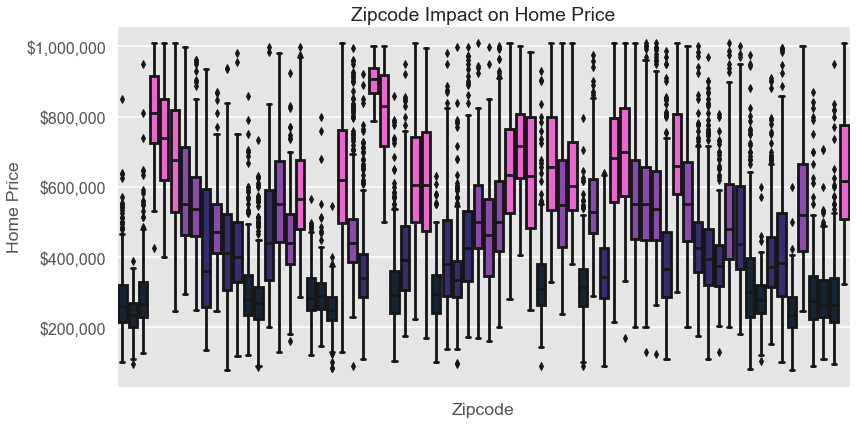

In [246]:
# Plot the effect of zipcode on home price.
fig, ax = plt.subplots(figsize=(12,6))

median_price = preprocessed.groupby('zipcode')['price'].median()

q1, q2, q3 = [median_price.quantile(x) for x in (0.25, 0.5, 0.75)]
colors = {zipcode: '#10253B' if mean_price[zipcode]<=q1
          else '#2B237C' if mean_price[zipcode]<=q2
          else '#8E39BD' if mean_price[zipcode]<=q3
          else '#FF51DB' for zipcode in preprocessed['zipcode'].values}

sns.boxplot(x='zipcode', y='price', data=preprocessed, palette=colors, ax=ax)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.set(title='Zipcode Impact on Home Price', 
       xlabel='Zipcode', ylabel='Home Price')
ax.set_xticklabels([])

fig.tight_layout()

This figure clearly shows how the location of a home (in terms of its zipcode) has a huge impact on what range of prices you can expect.Some neighborhoods have almost no homes selling for less than \$600,000, while others have no homes *more valuable* than \$400,000.

In [221]:
table.drop([r for r in table.index 
            if r.startswith('zipcode')])

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
waterfront_1_0,260200.0000,12300.000,21.173,0.0,236000.000,284000.000
renovated_1_0,50440.0000,3507.086,14.382,0.0,43600.000,57300.000
grade,37320.0000,933.248,39.989,0.0,35500.000,39100.000
condition,29870.0000,978.057,30.543,0.0,28000.000,31800.000
sqft_above,103.6368,1.484,69.840,0.0,100.728,106.545
sqft_basement,75.6146,1.666,45.388,0.0,72.349,78.880
sqft_living15,47.2232,1.661,28.430,0.0,43.967,50.479
sqft_lot,0.3386,0.016,21.123,0.0,0.307,0.370


## Waterfront / Renovated

The next two factors which makes a huge difference are **whether or not the house in on the water** and **whether or not a house has been renovated**

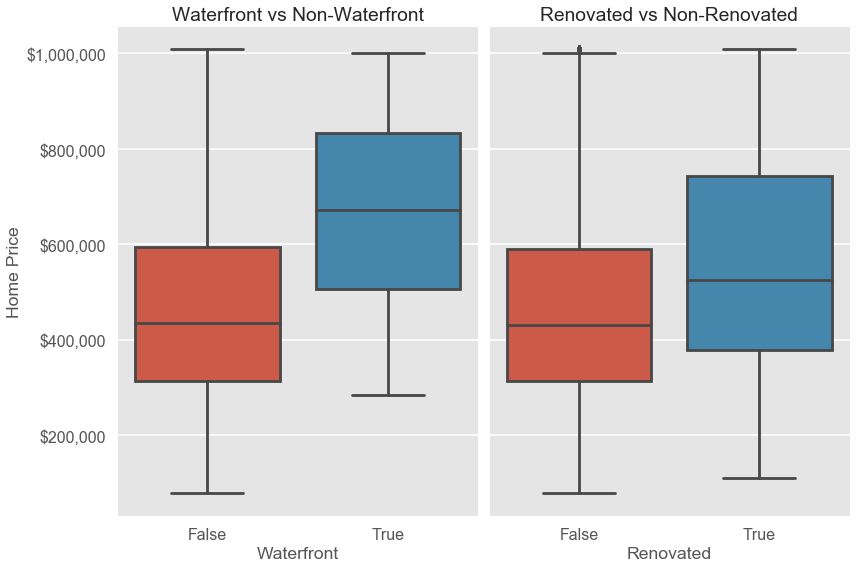

In [253]:
# Plot the effect of waterfront on price.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,8))

sns.boxplot(x='waterfront', y='price', data=preprocessed, ax=ax1)
sns.boxplot(x='renovated', y='price', data=preprocessed, ax=ax2)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax1.set(title="Waterfront vs Non-Waterfront", 
       xlabel='Waterfront', ylabel='Home Price')
ax2.set(title="Renovated vs Non-Renovated", 
       xlabel='Renovated', ylabel='')
for ax in (ax1, ax2):
    ax.set_xticklabels(['False', 'True'])

fig.tight_layout()

The difference between having a property on the `waterfront` is worth over \$260,000!

Similarly, the affect of having your home `renovated` or not proves to have a big impact. The difference is worth over \$50,000.

## Grade

Finally, there is a very big correlation between `grade` and `price`.
> **Grade:** *overall grade given to the housing unit, based on King County grading system*

This refers to the grade of the building (the higher the grade, the better the building is).

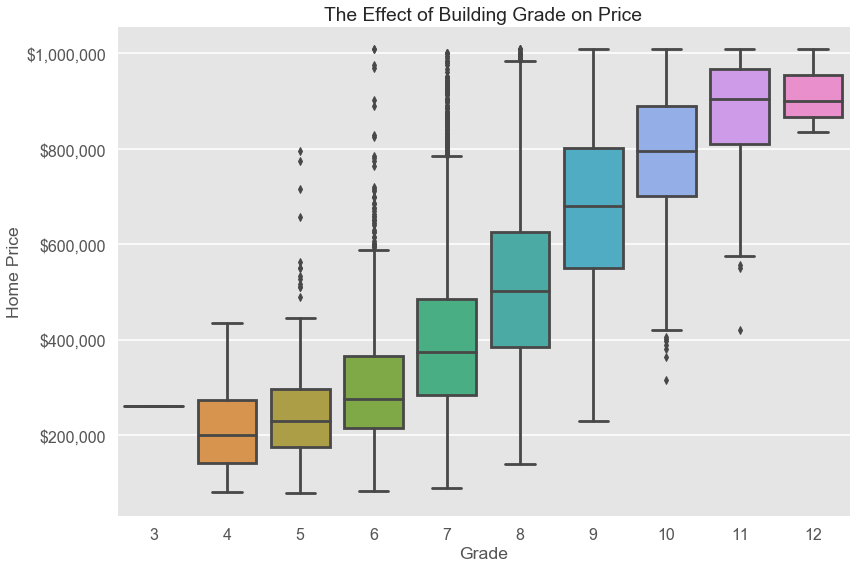

In [270]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=preprocessed)
ax.set(title='The Effect of Building Grade on Price', 
       xlabel='Grade', ylabel='Home Price')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

fig.tight_layout()

For each step up in `grade`, the affect on price is +\$37,000.

## A note on `sqft_above`

As as aside, I'd like to have a look at `sqft_above`, a column which has a coefficient of `103.6368` (meaning for every square foot bigger, your house will increase in value by \$104.64).

This could be a very useful bit of information for sellers. *If an addition can be constructed for less than $104.64/ft^{2}$, it would be a worthwhile addition. (This assumes that another bedroom or bathroom or floor is **not** added, as that would alter other predictors as well.)*



# Conclusion

We can say without question that the top two most important features of a home are its **location**. (Apparently the old adage about *location, location, location* in real estate exists fro a reason.) 

Having a home in certain neighborhoods increases (or decreases) the value of your home considerably. This makes sense, as you can imagine a home in the middle of the desert will be worth much less than the same home on Laguna Beach.

The next most important factors are the **building itself** - both the building grade and whether or not it has been renovated have large impacts to the price of the home.

For sellers, it is important to take note that the *quality* and *location* of the building is more important than the size or number of bathrooms or the yard.